# NYSIF - John Donahue evaluation - Assignment #2 
### Submitted: August 15 2025
##  Assignment 2 – Replicating Portfolio

> Objective: Replicate the performance of <b>MTUM</b> (iShares MSCI USA Momentum Factor ETF) using a sparse portfolio from specified ETFs.

In [16]:
import sys, os
######  Basic Libraries ################################
import pandas as pd
import numpy as np
########################################################
import duckdb as ddb
########################################################
from datetime import datetime, timedelta
########################################################
#import matplotlib.pyplot as plt
########################################################
import warnings
warnings.filterwarnings('ignore')
import time 
########################################################
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.max_columns', None)

## Custom Functions for XGBClassifier, Portfolio Optimization and Analysis


In [17]:
from portfolio_precleaning         import clean_portfolio_data_for_period,clean_data_pipeline_step
######################################################################################################################################################
from xgb_portfolio_model           import (binary_classifier, predict_next_month_portfolio, prepare_next_month_target ,
                                           train_xgb_portfolio_model, plot_model_performance, generate_monthly_portfolio_predictions)
######################################################################################################################################################
from expected_returns_models       import (calculate_momentum_factors, calculate_mean_reversion_factors, calculate_volatility_factors,
                                           build_factor_model_returns, backtest_expected_returns, plot_expected_returns_comparison,
                                           integrate_expected_returns_with_optimizer, prepare_returns_matrix_safe ) 
######################################################################################################################################################
from portfolio_optimization        import (prepare_cvxpy_data, optimize_portfolio_cvxpy, compare_regularization_levels, plot_cvxpy_portfolio,
                                          calculate_portfolio_returns, calculate_benchmark_comparison_metrics, print_benchmark_comparison,
                                          plot_benchmark_comparison, prepare_benchmark_returns)
######################################################################################################################################################
from backtest_storage              import BacktestResultsStorage,calculate_transaction_costs
######################################################################################################################################################
from portfolio_performance_summary import (calculate_key_statistics, print_key_statistics_table,
                                          plot_portfolio_performance_visuals, generate_portfolio_performance_report, create_full_backtest_analysis)
######################################################################################################################################################
from save_results                  import organize_backtest_outputs, organize_backtest_outputs_simple


## 🔢 Data Acquisition:

  - Daily Adj Close (and volume if needed) for MTUM and the following ETFs:

    [XLE, XLF, XLU, XLI, XLK, XLV, XLY, XLP, XLB, SMH, AIQ] (up to 20 years)
  
  - <b>Handle corporate actions, missing data, and survivorship bias.</b>
    - Corporate Actions - yFinance : Adj_Close - Adj_Close for Dividends, Spits
    - Missing Data      - Forward Fill any missing values from last value
    - Suviorship Bias   - Start Analysis from MTUM Inception Date

#### Setup Benchmark Tickers, Portfolio Tickers

In [18]:
tickers = ['MTUM', 'XLE', 'XLF', 'XLU', 'XLI', 'XLK', 'XLV', 'XLY', 'XLP', 'XLB', 'SMH', 'AIQ']
benchmark         = 'MTUM'
portfolio_tickers = ['XLE', 'XLF', 'XLU', 'XLI', 'XLK', 'XLV', 'XLY', 'XLP', 'XLB', 'SMH', 'AIQ']
#raw_data = yf.download(tickers, period='20y', auto_adjust=False, interval='1d')
try:
    raw_data  = pd.read_parquet('raw_data.parquet')
    display(raw_data.head())
except Exception as e:
    print(f"No Raw Data File - Download or Create\n Exception {e}")


Price      Adj Close                                                       \
Ticker           AIQ MTUM     SMH     XLB     XLE     XLF     XLI     XLK   
Date                                                                        
2005-08-15       NaN  NaN 15.6307 18.5674 28.0200 16.2106 20.5826 16.0810   
2005-08-16       NaN  NaN 15.4050 18.2073 27.4052 16.1019 20.3451 15.9272   
2005-08-17       NaN  NaN 15.5796 18.1880 26.7735 16.1400 20.3994 16.0657   
2005-08-18       NaN  NaN 15.4433 18.0336 26.7171 16.1291 20.3112 15.9579   
2005-08-19       NaN  NaN 15.4348 18.0722 27.1740 16.1563 20.3926 15.9733   

Price                                      Close                               \
Ticker         XLP     XLU     XLV     XLY   AIQ MTUM     SMH     XLB     XLE   
Date                                                                            
2005-08-15 13.7500 15.9115 22.6054 26.9238   NaN  NaN 18.3500 28.8700 49.6800   
2005-08-16 13.6137 15.6618 22.4488 26.3652   NaN  NaN 18.0850 28.3100 48.5900   
2005-08-17 13.6077 15.6468 22.4915 26.5204   NaN  NaN 18.2900 28.2800 47.4700   
2005-08-18 13.7619 15.7067 22.4987 26.4117   NaN  NaN 18.1300 28.0400 47.3700   
2005-08-19 13.7441 15.8016 22.3421 26.2798   NaN  NaN 18.1200 28.1000 48.1800   

Price                                                              High       \
Ticker         XLF     XLI     XLK     XLP     XLU     XLV     XLY  AIQ MTUM   
Date                                                                           
2005-08-15 24.2486 30.3300 20.9000 23.1900 31.8600 31.7700 34.7000  NaN  NaN   
2005-08-16 24.0861 29.9800 20.7000 22.9600 31.3600 31.5500 33.9800  NaN  NaN   
2005-08-17 24.1430 30.0600 20.8800 22.9500 31.3300 31.6100 34.1800  NaN  NaN   
2005-08-18 24.1267 29.9300 20.7400 23.2100 31.4500 31.6200 34.0400  NaN  NaN   
2005-08-19 24.1673 30.0500 20.7600 23.1800 31.6400 31.4000 33.8700  NaN  NaN   

Price                                                                       \
Ticker         SMH     XLB     XLE     XLF     XLI     XLK     XLP     XLU   
Date                                                                         
2005-08-15 18.4750 28.9500 50.1000 24.2973 30.4000 20.9900 23.2400 31.8900   
2005-08-16 18.2300 28.8600 49.7200 24.3542 30.2900 20.9000 23.1600 31.8900   
2005-08-17 18.3850 28.4100 49.1000 24.2323 30.2100 20.9800 23.0100 31.4500   
2005-08-18 18.2700 28.2300 47.6700 24.1917 30.0900 20.9000 23.2800 31.5000   
2005-08-19 18.2800 28.3300 48.3200 24.2486 30.2000 20.8800 23.2800 31.6700   

Price                      Low                                               \
Ticker         XLV     XLY AIQ MTUM     SMH     XLB     XLE     XLF     XLI   
Date                                                                          
2005-08-15 31.8500 34.7200 NaN  NaN 18.1250 28.6300 49.5000 24.0292 30.0600   
2005-08-16 31.8500 34.6800 NaN  NaN 18.0150 28.3100 48.5700 24.0861 29.9600   
2005-08-17 31.7500 34.3000 NaN  NaN 18.1850 28.1500 47.2500 24.0455 29.8600   
2005-08-18 31.7700 34.1600 NaN  NaN 18.1250 28.0300 46.8700 24.0130 29.9000   
2005-08-19 31.8500 34.2000 NaN  NaN 18.0800 28.0500 47.6500 24.1348 30.0400   

Price                                              Open                       \
Ticker         XLK     XLP     XLU     XLV     XLY  AIQ MTUM     SMH     XLB   
Date                                                                           
2005-08-15 20.7500 23.0400 31.6600 31.6300 34.3100  NaN  NaN 18.1950 28.8000   
2005-08-16 20.6600 22.9500 31.3600 31.5400 33.9700  NaN  NaN 18.2250 28.8600   
2005-08-17 20.7500 22.8600 31.0400 31.5100 33.9500  NaN  NaN 18.2050 28.1500   
2005-08-18 20.7400 22.9000 31.0600 31.5300 33.9200  NaN  NaN 18.2400 28.2000   
2005-08-19 20.7600 23.1700 31.4900 31.3900 33.8700  NaN  NaN 18.1950 28.2500   

Price                                                                       \
Ticker         XLE     XLF     XLI     XLK     XLP     XLU     XLV     XLY   
Date                                  

### Flatten Raw yFinance Data to Single Pandas DataFrame
  - Raw Data from yfinance is in an unwieldy format, prefer to flatten data for later usage

In [19]:
display(raw_data.tail(2))
intermin_data           = raw_data.copy()
intermin_data.columns   = pd.MultiIndex.from_tuples(intermin_data.columns)
reshaped                = intermin_data.stack(level=1,  future_stack=True)
reshaped                = reshaped.swaplevel().sort_index()
reshaped                = reshaped.rename(columns={"Adj Close": "Adj_Close"})  # optional rename
reshaped.index.set_names(["Ticker", "Date"], inplace=True)
reshaped.reset_index(drop=False, inplace=True)
display(reshaped.tail(2))

Price      Adj Close                                                     \
Ticker           AIQ     MTUM      SMH     XLB     XLE     XLF      XLI   
Date                                                                      
2025-08-12   45.3400 247.8600 300.1000 89.3000 84.6600 52.4600 151.9000   
2025-08-13   45.4700 245.2550 299.2100 90.3400 84.8050 52.5125 151.1100   

Price                                                   Close           \
Ticker          XLK     XLP     XLU      XLV      XLY     AIQ     MTUM   
Date                                                                     
2025-08-12 268.2100 82.6300 86.2800 131.1900 226.7400 45.3400 247.8600   
2025-08-13 267.5100 82.7800 85.8650 133.1750 229.2100 45.4700 245.2550   

Price                                                                          \
Ticker          SMH     XLB     XLE     XLF      XLI      XLK     XLP     XLU   
Date                                                                            
2025-08-12 300.1000 89.3000 84.6600 52.4600 151.9000 268.2100 82.6300 86.2800   
2025-08-13 299.2100 90.3400 84.8050 52.5125 151.1100 267.5100 82.7800 85.8650   

Price                           High                                    \
Ticker          XLV      XLY     AIQ     MTUM      SMH     XLB     XLE   
Date                                                                     
2025-08-12 131.1900 226.7400 45.3650 248.0000 300.2400 89.3800 85.4000   
2025-08-13 133.1750 229.2100 45.7700 248.9000 302.9700 90.3400 85.2787   

Price                                                                   \
Ticker         XLF      XLI      XLK     XLP     XLU      XLV      XLY   
Date                                                                     
2025-08-12 52.5500 151.9600 268.2800 82.7000 86.3000 131.2300 227.0000   
2025-08-13 52.9100 152.4600 270.0500 82.7800 86.5200 133.1800 229.6500   

Price          Low                                                     \
Ticker         AIQ     MTUM      SMH     XLB     XLE     XLF      XLI   
Date                                                                    
2025-08-12 44.6200 245.8800 293.1500 88.2100 84.1700 52.0400 150.6800   
2025-08-13 45.4635 245.2400 298.5700 89.5200 84.4200 52.4850 150.7400   

Price                                                    Open           \
Ticker          XLK     XLP     XLU      XLV      XLY     AIQ     MTUM   
Date                                                                     
2025-08-12 263.9700 82.2600 85.5100 130.1300 224.4600 44.9180 246.9400   
2025-08-13 267.4000 81.9300 85.6700 131.6500 227.3500 45.6300 248.7300   

Price                                                                          \
Ticker          SMH     XLB     XLE     XLF      XLI      XLK     XLP     XLU   
Date                                                                            
2025-08-12 295.2900 88.3000 84.4200 52.0500 150.9700 265.4400 82.5200 86.1900   
2025-08-13 301.8050 89.7600 84.7200 52.6600 152.3300 269.7600 82.1900 86.4000   

Price                              Volume                                \
Ticker          XLV      XLY          AIQ        MTUM      SMH      XLB   
Date                                                                      
2025-08-12 130.3400 226.0600 1104800.0000 653200.0000  7592800  6250600   
2025-08-13 131.8200 227.5900  765410.0000 483919.0000  5109648  4884866   

Price                                                                 \
Ticker           XLE       XLF      XLI      XLK       XLP       XLU   
Date                                                                   
2025-08-12  17261300  37510000  9518300  5576900  16449500  10378400   
2025-08-13   7420651  22869903  8100017  3670399  10680964   6319061   

Price                          
Ticker           XLV      XLY  
Date                           
2025-08-12  17219500  4895700  
2025-08-13   9324162  3617824

,Ticker,Date,Adj_Close,Close,High,Low,Open,Volume
60370,XLY,2025-08-12,226.7400,226.7400,227.0000,224.4600,226.0600,4895700.0000
60371,XLY,2025-08-13,229.2100,229.2100,229.6500,227.3500,227.5900,3617824.0000


### DuckDB utilities
- DuckDB has very powerful tools to query pandas dataframes like SQL tables
- extremely useful and powerful
- Quick to Find where the start dates for all the other ETF's
> Replicating this with native Pandas tools is a bit cumbersome, but DuckDB makes it managable.  <br> <u>SELECT MIN(Date) FROM reshaped WHERE Ticker = 'MTUM' AND Date IS NOT NULL AND Adj_Close IS NOT NULL </u>


In [20]:
## MTUM Inception Date ###########################
inception_date  = ddb.sql("SELECT MIN(Date) FROM reshaped WHERE Ticker = 'MTUM' AND Date IS NOT NULL AND Adj_Close IS NOT NULL").df().iloc[0,0].date()
inception_date  = pd.to_datetime(inception_date)
end_date        = pd.to_datetime(datetime.now().date())

#### ETF Details #################################
print("\nETF Details\n\nTicker Symbol, Inception Date, Record Count\n")
etf_details = {}
for t in tickers:
  etf_details[t] = { 'inception_date' : ddb.sql("SELECT MIN(Date) FROM reshaped WHERE Ticker = \'" + t + "\' AND Date IS NOT NULL AND Adj_Close IS NOT NULL").fetchall()[0][0],
                     'record_count'   : ddb.sql("SELECT COUNT(*)  FROM reshaped WHERE Ticker = \'" + t + "\' AND Date IS NOT NULL AND Adj_Close IS NOT NULL").fetchall()[0][0]}
details = pd.DataFrame.from_dict(etf_details, orient='index').sort_values(by='inception_date', ascending=False).reset_index(drop=False)
details.columns = ['Ticker', 'inception_date', 'record_count']
display(details.style.background_gradient(subset=['inception_date'], cmap='Blues'))
###################################################
#######  Most Recent ETF Inception Date ###########
most_recent_ticker, most_recent_date = ddb.sql("SELECT Ticker, MIN(inception_date) AS latest FROM details GROUP BY Ticker  ORDER BY latest DESC LIMIT 1").df().values[0]
print(f"\n{most_recent_ticker} is the Ticker with the Most Recent Inception : {most_recent_date.date()}")
print(f"MTUM Start Date: {inception_date} : ALL Data Start Date: {inception_date} : ALL Data End Date: {end_date}")
print(f"Therefore we know - we will 1 less ETF up until 2018-05 for inclusion in the portfolio")


ETF Details

Ticker Symbol, Inception Date, Record Count



,Ticker,inception_date,record_count
0,AIQ,2018-05-16 00:00:00,1821
1,MTUM,2013-04-18 00:00:00,3100
2,XLE,2005-08-15 00:00:00,5031
3,XLF,2005-08-15 00:00:00,5031
4,XLU,2005-08-15 00:00:00,5031
5,XLI,2005-08-15 00:00:00,5031
6,XLK,2005-08-15 00:00:00,5031
7,XLV,2005-08-15 00:00:00,5031
8,XLY,2005-08-15 00:00:00,5031
9,XLP,2005-08-15 00:00:00,5031



AIQ is the Ticker with the Most Recent Inception : 2018-05-16
MTUM Start Date: 2013-04-18 00:00:00 : ALL Data Start Date: 2013-04-18 00:00:00 : ALL Data End Date: 2025-08-15 00:00:00
Therefore we know - we will 1 less ETF up until 2018-05 for inclusion in the portfolio


### Split Reshaped Data into Portfolio Data and Benchmark Data
  - Integrity Check on Record Counts
  - Peek in to data

In [21]:
port_mask = (reshaped['Ticker'].isin(portfolio_tickers)) &  ((reshaped['Date'] >= inception_date) & (reshaped['Date'] <= end_date))
portfolio_data = reshaped[port_mask]
print(f"Total Portfolio Records: {portfolio_data.shape[0]}")
for ticker in portfolio_tickers:
  print(f"Total {ticker} Records: {portfolio_data[portfolio_data['Ticker'] == ticker].shape[0]}")
display(portfolio_data.tail(2))
bm_mask = (reshaped['Ticker'].isin([benchmark])) &  ((reshaped['Date'] >=  inception_date) & (reshaped['Date'] <= end_date))
benchmark_data = reshaped[bm_mask]
print(f"Total Benchmark Records: {benchmark_data.shape[0]}")
display(benchmark_data.tail(2))


Total Portfolio Records: 34100
Total XLE Records: 3100
Total XLF Records: 3100
Total XLU Records: 3100
Total XLI Records: 3100
Total XLK Records: 3100
Total XLV Records: 3100
Total XLY Records: 3100
Total XLP Records: 3100
Total XLB Records: 3100
Total SMH Records: 3100
Total AIQ Records: 3100


,Ticker,Date,Adj_Close,Close,High,Low,Open,Volume
60370,XLY,2025-08-12,226.7400,226.7400,227.0000,224.4600,226.0600,4895700.0000
60371,XLY,2025-08-13,229.2100,229.2100,229.6500,227.3500,227.5900,3617824.0000


Total Benchmark Records: 3100


,Ticker,Date,Adj_Close,Close,High,Low,Open,Volume
10060,MTUM,2025-08-12,247.8600,247.8600,248.0000,245.8800,246.9400,653200.0000
10061,MTUM,2025-08-13,245.2550,245.2550,248.9000,245.2400,248.7300,483919.0000


## Get the MTUM Month-End Dates for First Draft of Rebalance dates

In [22]:
monthly_dates = benchmark_data.set_index('Date', drop=False).resample('ME').agg({'Adj_Close': 'last'}).reset_index(drop=False)
monthly_dates = [d.strftime('%Y-%m-%d') for d in monthly_dates['Date'].to_list()]
print(f"Month-End Dates: ") # {monthly_dates}")
column_width = 10  # Adjust this value based on the longest date string

for i, m in enumerate(monthly_dates):
    # Use an f-string to format each date within a fixed width, left-aligned
    print(f"{m:<{column_width}}", end=" , ")

    # Print a newline character after every 5th item
    if (i + 1) % 5 == 0:
        print()

# Add a final newline if the last line wasn't fully filled (not a multiple of 5)
if len(monthly_dates) % 5 != 0:
    print()


Month-End Dates: 
2013-04-30 , 2013-05-31 , 2013-06-30 , 2013-07-31 , 2013-08-31 , 
2013-09-30 , 2013-10-31 , 2013-11-30 , 2013-12-31 , 2014-01-31 , 
2014-02-28 , 2014-03-31 , 2014-04-30 , 2014-05-31 , 2014-06-30 , 
2014-07-31 , 2014-08-31 , 2014-09-30 , 2014-10-31 , 2014-11-30 , 
2014-12-31 , 2015-01-31 , 2015-02-28 , 2015-03-31 , 2015-04-30 , 
2015-05-31 , 2015-06-30 , 2015-07-31 , 2015-08-31 , 2015-09-30 , 
2015-10-31 , 2015-11-30 , 2015-12-31 , 2016-01-31 , 2016-02-29 , 
2016-03-31 , 2016-04-30 , 2016-05-31 , 2016-06-30 , 2016-07-31 , 
2016-08-31 , 2016-09-30 , 2016-10-31 , 2016-11-30 , 2016-12-31 , 
2017-01-31 , 2017-02-28 , 2017-03-31 , 2017-04-30 , 2017-05-31 , 
2017-06-30 , 2017-07-31 , 2017-08-31 , 2017-09-30 , 2017-10-31 , 
2017-11-30 , 2017-12-31 , 2018-01-31 , 2018-02-28 , 2018-03-31 , 
2018-04-30 , 2018-05-31 , 2018-06-30 , 2018-07-31 , 2018-08-31 , 
2018-09-30 , 2018-10-31 , 2018-11-30 , 2018-12-31 , 2019-01-31 , 
2019-02-28 , 2019-03-31 , 2019-04-30 , 2019-05-31 , 2019-0

# When to Start the Replication?
## Justification
- Requirement for 1 of the Features is:
  - 12 Month Momentum
    - Therefore we need 13 months of Data to calculate the Momentum Correctly
    - And we will FFILL (Forward Fill) the Missing Data in the daily Data
      -But:
      - Since we need 12 months of data to Forward Fill for the next 12 months
      - and we need the 12 month momentum as a feature
      - and 12 month Lagged momentum needs 13 months of data
          - We need to Step Forward in out Analysis - 25 months!
      - and we are rebalancing monthly
      - and it is 2025
  - it is resonable to start the analysis in 2015


### Therefore Our Start Date for the Analysis is  
#### 05/18/2015  
### Therefore our first "Month End" Rebalancing is
#####  05/31/2015
### And our Last Rebalancing is
##### 07/31/2025

In [23]:
########################################################################
portfolio_start_date = inception_date + pd.DateOffset(months=25)
########################################################################
print(f"MTUM Start Date: {inception_date.date()} : Analysis Data Start Date: {portfolio_start_date.date()} : Analysis Data End Date: {end_date.date()}\n")
########################################################################
print(f"We will have a new ETF : Most Recent Ticker {most_recent_ticker} starting on {most_recent_date.date()} and will have the same issue, cannot include until {(most_recent_date + pd.offsets.MonthEnd(25)).date()}")
########################################################################
print(f"\nNEW Month-End Dates: \n")
new_month_end_dates = [d for d in monthly_dates if pd.to_datetime(d) >= portfolio_start_date]
column_width = 10  # Adjust this value based on the longest date string
new_month_end_dates = new_month_end_dates[:-1]  
for i, m in enumerate(new_month_end_dates):
    # Use an f-string to format each date within a fixed width, left-aligned
    print(f"{m:<{column_width}}", end=" , ")
    # Print a newline character after every 5th item
    if (i + 1) % 5 == 0:
        print()

# # Add a final newline if the last line wasn't fully filled (not a multiple of 5)
# if len(new_month_end_dates) % 5 != 0:
#     print()



MTUM Start Date: 2013-04-18 : Analysis Data Start Date: 2015-05-18 : Analysis Data End Date: 2025-08-15

We will have a new ETF : Most Recent Ticker AIQ starting on 2018-05-16 and will have the same issue, cannot include until 2020-05-31

NEW Month-End Dates: 

2015-05-31 , 2015-06-30 , 2015-07-31 , 2015-08-31 , 2015-09-30 , 
2015-10-31 , 2015-11-30 , 2015-12-31 , 2016-01-31 , 2016-02-29 , 
2016-03-31 , 2016-04-30 , 2016-05-31 , 2016-06-30 , 2016-07-31 , 
2016-08-31 , 2016-09-30 , 2016-10-31 , 2016-11-30 , 2016-12-31 , 
2017-01-31 , 2017-02-28 , 2017-03-31 , 2017-04-30 , 2017-05-31 , 
2017-06-30 , 2017-07-31 , 2017-08-31 , 2017-09-30 , 2017-10-31 , 
2017-11-30 , 2017-12-31 , 2018-01-31 , 2018-02-28 , 2018-03-31 , 
2018-04-30 , 2018-05-31 , 2018-06-30 , 2018-07-31 , 2018-08-31 , 
2018-09-30 , 2018-10-31 , 2018-11-30 , 2018-12-31 , 2019-01-31 , 
2019-02-28 , 2019-03-31 , 2019-04-30 , 2019-05-31 , 2019-06-30 , 
2019-07-31 , 2019-08-31 , 2019-09-30 , 2019-10-31 , 2019-11-30 , 
2019-12-31 ,

<hr>
<hr>
<hr>

# Monthly Loop steps:
    * Update features
    * Score securities with model
    * Select securities
    * Minimize ex-ante tracking error to MTUM under constraints (weights ≥ 0, sum to 1, L1 penalty)
    * Record weights
    * Compute daily returns


## 📐 Feature Engineering:

Compute for each security:


*   1-, 3-, 6-, 12-month momentum
*   20-, 60-day volatility
*   60-day realized correlation with MTUM
*   Optional: size, P/E, earnings surprises

Standardize features as needed.

## 🏷️ Label Creation:

* For each monthly rebalancing date, solve an in-sample optimization to minimize tracking error to MTUM under an L1 sparsity penalty.
* Label selected tickers as 1; others as 0.


## 🤖 Model Development:

* Train a classifier (XGBoost or LightGBM preferred).
  Use cross-validation.
* Report AUC and feature importance.

## 📊 Portfolio Construction & Backtesting:

* Monthly steps:
    * Update features
    * Score securities with model
    * Select securities
    * Minimize ex-ante tracking error to MTUM under constraints (weights ≥ 0, sum to 1, L1 penalty)
    * Record weights
    * Compute daily returns


**Configure Analysis Period** (Cell ~8-9):
   - From Cell 8: Review the Month End Dates array
   - In Cell 9: Set these variables to control analysis scope:
     ```python
     START_INDEX = -6    # Start from 6th month from end
     END_INDEX = -1      # End at last month
     ```
   - **Recommendation**: Start with 5-6 months for faster execution
   - For full analysis (24+ months), allow 2-3 hours runtime

In [24]:
START_INDEX = -9
END_INDEX   = -1

print(f"Date we Start : {new_month_end_dates[START_INDEX]}")
print(f"Date we End   : {new_month_end_dates[END_INDEX]}")


Date we Start : 2024-11-30
Date we End   : 2025-07-31


In [25]:
st = time.time()

# Begin Primary Monthly Analysis / Backtest / MTUM Portfolio Replication

- This is the main entry point for the monthly portfolio rebalance and backtesting

### Toggle BULK MODE ### 
##### Bulk mode toggles on and off for the detail level at the end of a month's processing's charts and metrics
-  **BULK_MODE = True**
    - Sparse output of metrics 
-  **BULK_MODE = False**
    - More detailed output at end of monthly run

**optional**
*Suggestion - Enable Bulk mode for runs over 24 months*
- Line - 32 - BULK_MODE = False        
               



Initialized backtest storage for 2024-11-30 to 2025-07-31
Benchmark: MTUM
Initialized backtest storage for 123 months
Period: 2024-11-30 to 2025-07-31

PROCESSING MONTH 1/2: 2024-11-30
Running 2024-11-30
Analysis Start Date: 2023-10-30 00:00:00 : Analysis End Date: 2024-11-30 00:00:00
🧹 Cleaning portfolio data for period: 2023-10-30 00:00:00 to 2024-11-30 00:00:00
   After date filter: 3,014 rows, 11 tickers
   Total trading days in period: 274
   Minimum required observations: 137 (50%)

   ✅ Keeping 11 tickers with sufficient data:
      AIQ: 274/274 days (100.0%)
      SMH: 274/274 days (100.0%)
      XLB: 274/274 days (100.0%)
      XLE: 274/274 days (100.0%)
      XLF: 274/274 days (100.0%)
      XLI: 274/274 days (100.0%)
      XLK: 274/274 days (100.0%)
      XLP: 274/274 days (100.0%)
      XLU: 274/274 days (100.0%)
      XLV: 274/274 days (100.0%)
      XLY: 274/274 days (100.0%)

   📊 Final cleaned data:
      Tickers: 11
      Date range: 2023-10-30 00:00:00 to 2024-11-29 0

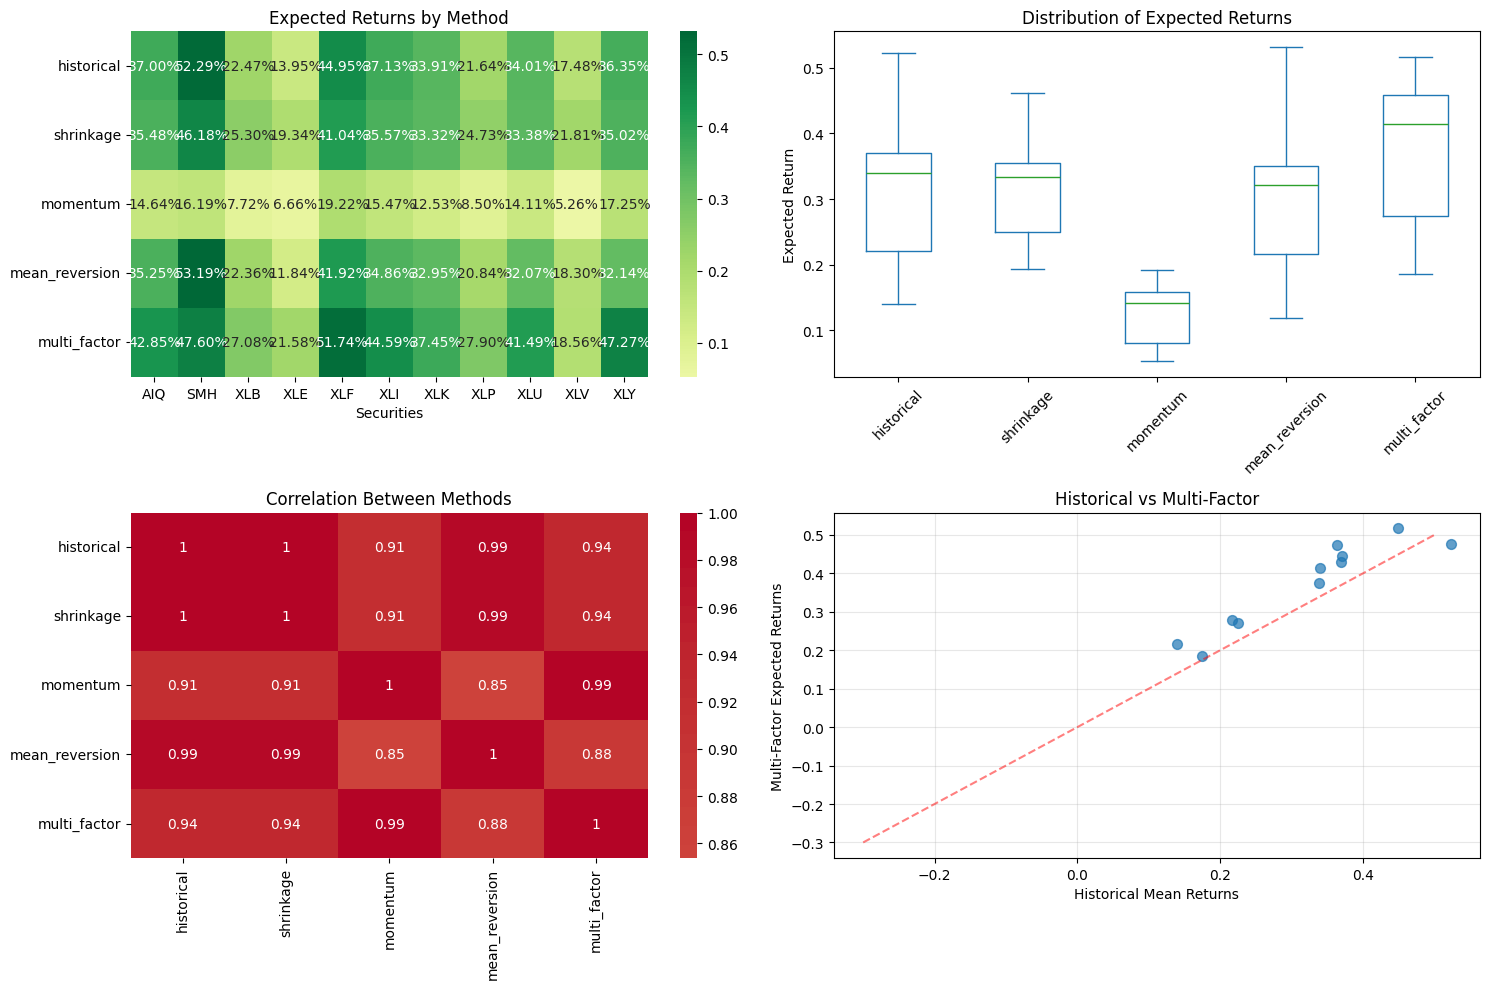


Best performing method: momentum
Preparing data for next month prediction...
Monthly dataset shape: (143, 19)
Using 9 features
Training set: 114 samples
Test set: 29 samples
Target distribution in training: {1.0: 110, 0.0: 4}
Starting hyperparameter tuning...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
Cross-validation AUC: nan
Test AUC: nan

Test Set Classification Report:
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        29

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29


Test Set Confusion Matrix:
[[29]]

Top 9 Most Important Features:
                      feature  importance
8            rolling_60d_corr      0.2460
5             rolling_s

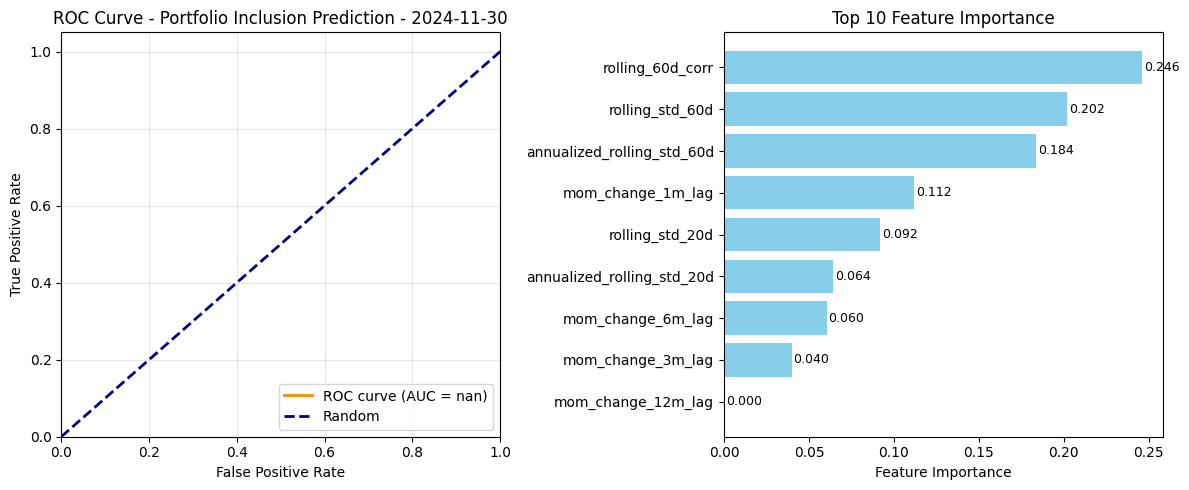


🔍 XGBoost Prediction Results for 2024-11-30:
Total securities evaluated: 11
  security current_month  predicted_include_next_month  inclusion_probability
0      XLB       2024-11                             1                 0.9974
1      XLI       2024-11                             1                 0.9958
2      XLV       2024-11                             1                 0.9947
3      XLP       2024-11                             1                 0.9934
4      AIQ       2024-11                             1                 0.9841
5      XLK       2024-11                             1                 0.9807
6      XLY       2024-11                             1                 0.9796
7      SMH       2024-11                             1                 0.9767
8      XLU       2024-11                             1                 0.9762
9      XLF       2024-11                             1                 0.9758
Portfolio for 2024-10:
  - Securities to include: 11
  - Top 5 pr

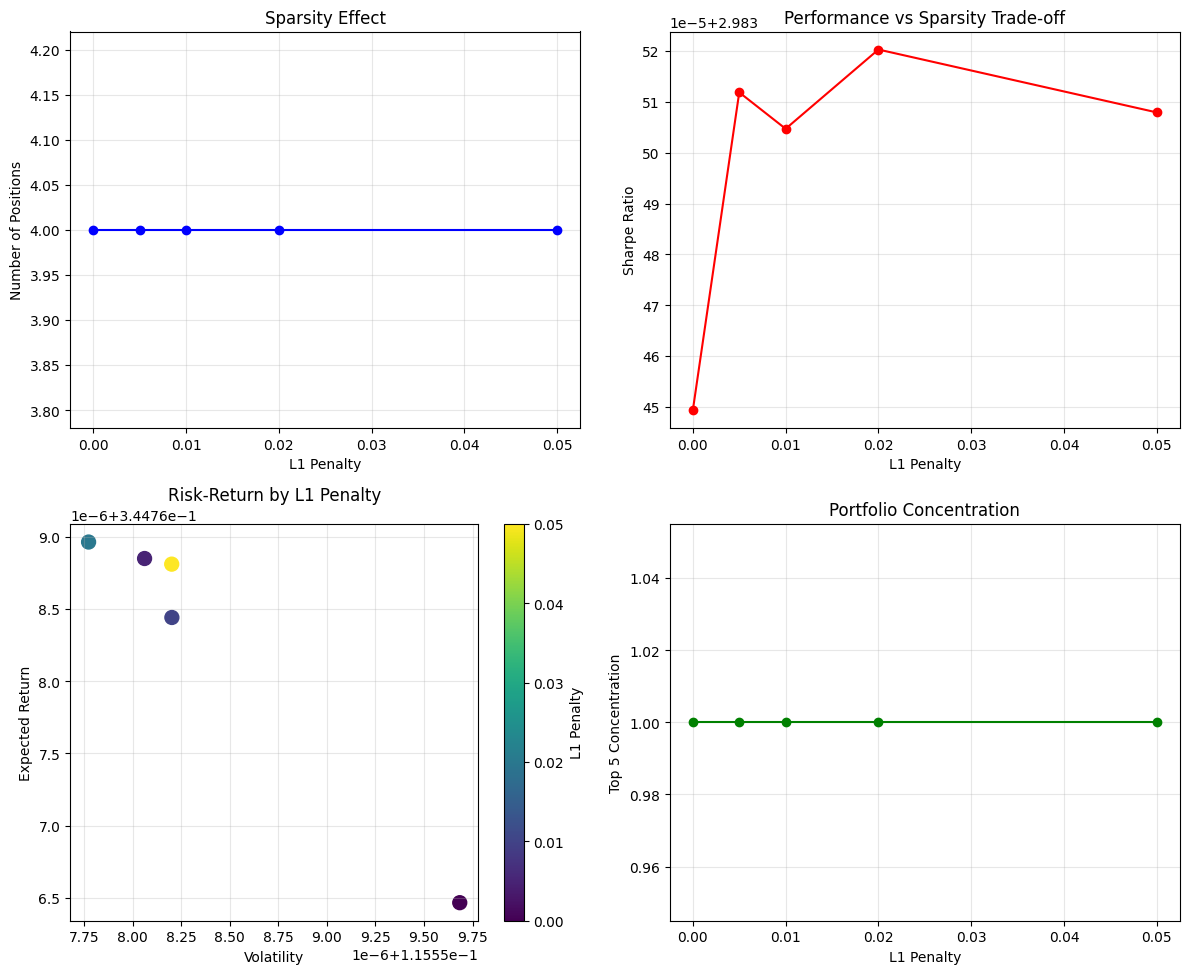


Regularization Comparison:
   L1_Penalty  Return  Volatility  Sharpe  Num_Positions  Max_Weight  \
0      0.0000  0.3448      0.1156  2.9834              4      0.3000   
1      0.0050  0.3448      0.1156  2.9835              4      0.3000   
2      0.0100  0.3448      0.1156  2.9835              4      0.3000   
3      0.0200  0.3448      0.1156  2.9835              4      0.3000   
4      0.0500  0.3448      0.1156  2.9835              4      0.3000   

   Top5_Concentration   Status  
0              1.0000  optimal  
1              1.0000  optimal  
2              1.0000  optimal  
3              1.0000  optimal  
4              1.0000  optimal  
Stored results for 2024-11-30 00:00:00: 4 positions, Expected Return: 13.25%
📊 Debug benchmark returns:
   Type: <class 'pandas.core.series.Series'>
   Shape: (20,)
   Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
   First few values: Date
2024-11-01   -0.0035
2024-11-04   -0.0019
2024-11-05    0.0168
Name: bm_ln_change

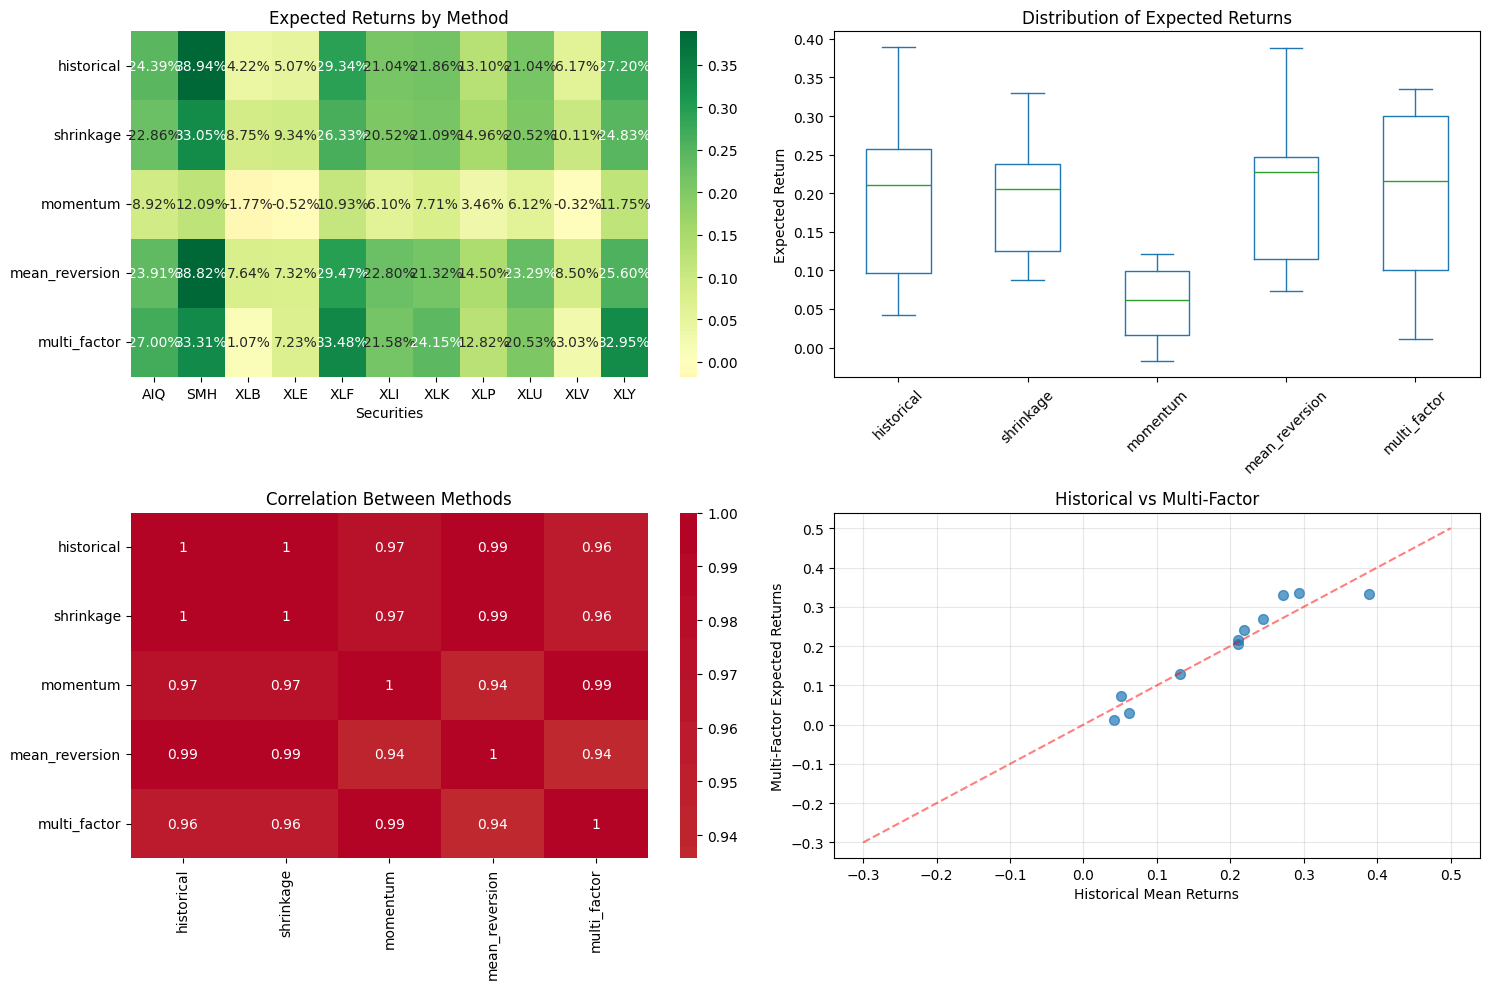


Best performing method: momentum
Preparing data for next month prediction...
Monthly dataset shape: (143, 19)
Using 9 features
Training set: 114 samples
Test set: 29 samples
Target distribution in training: {1.0: 109, 0.0: 5}
Starting hyperparameter tuning...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.9}
Cross-validation AUC: 0.9012
Test AUC: nan

Test Set Classification Report:
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        29

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29


Test Set Confusion Matrix:
[[29]]

Top 9 Most Important Features:
                      feature  importance
8            rolling_60d_corr      0.3063
7  annualized_rollin

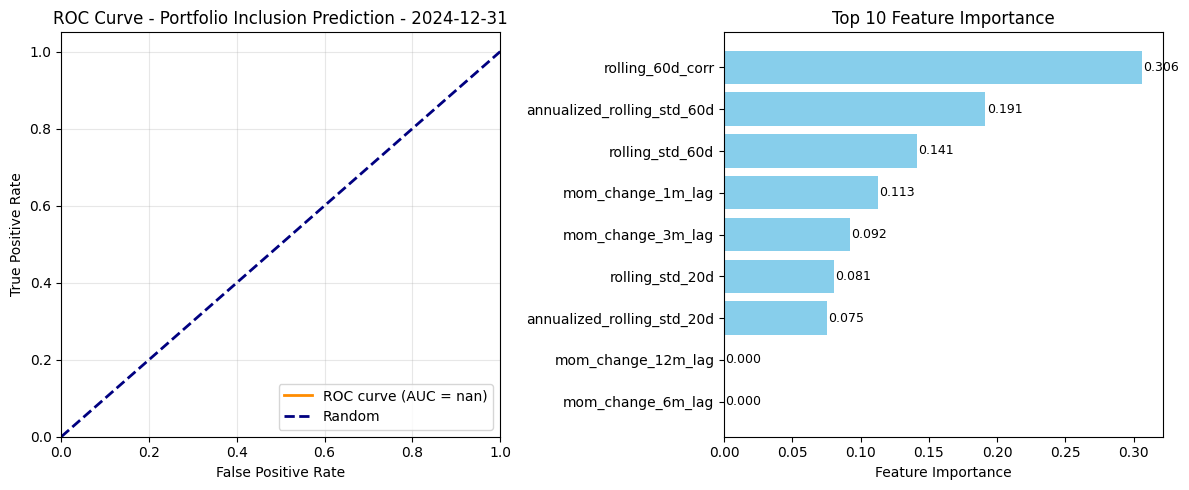


🔍 XGBoost Prediction Results for 2024-12-31:
Total securities evaluated: 11
  security current_month  predicted_include_next_month  inclusion_probability
0      XLI       2024-12                             1                 0.9953
1      XLB       2024-12                             1                 0.9952
2      XLV       2024-12                             1                 0.9951
3      XLP       2024-12                             1                 0.9915
4      XLU       2024-12                             1                 0.9873
5      XLF       2024-12                             1                 0.9864
6      XLE       2024-12                             1                 0.9846
7      XLK       2024-12                             1                 0.9835
8      XLY       2024-12                             1                 0.9835
9      SMH       2024-12                             1                 0.9827
Portfolio for 2024-11:
  - Securities to include: 11
  - Top 5 pr

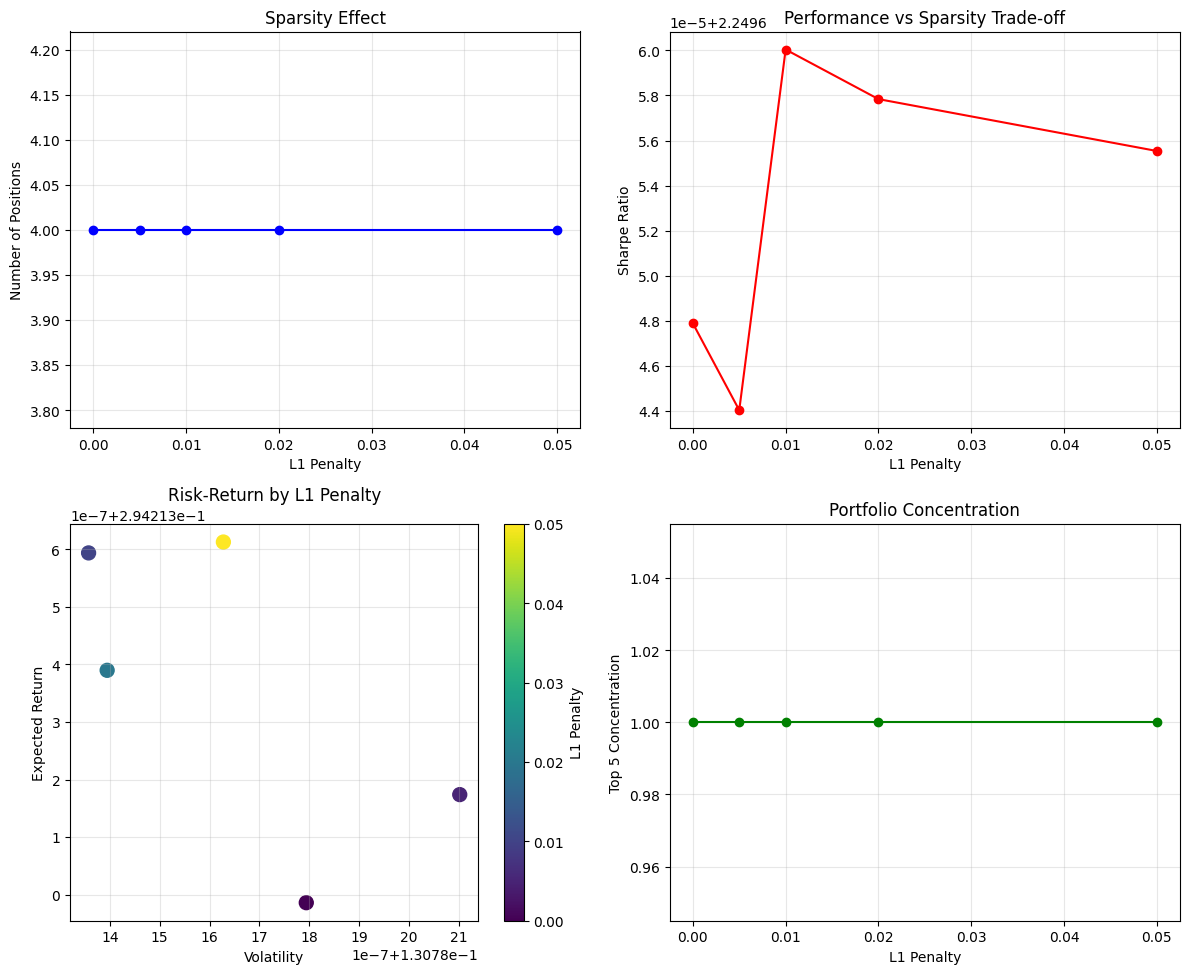


Regularization Comparison:
   L1_Penalty  Return  Volatility  Sharpe  Num_Positions  Max_Weight  \
0      0.0000  0.2942      0.1308  2.2496              4      0.3000   
1      0.0050  0.2942      0.1308  2.2496              4      0.3000   
2      0.0100  0.2942      0.1308  2.2497              4      0.3000   
3      0.0200  0.2942      0.1308  2.2497              4      0.3000   
4      0.0500  0.2942      0.1308  2.2497              4      0.3000   

   Top5_Concentration   Status  
0              1.0000  optimal  
1              1.0000  optimal  
2              1.0000  optimal  
3              1.0000  optimal  
4              1.0000  optimal  
Stored results for 2024-12-31 00:00:00: 4 positions, Expected Return: 9.54%
📊 Debug benchmark returns:
   Type: <class 'pandas.core.series.Series'>
   Shape: (21,)
   Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
   First few values: Date
2024-12-02   -0.0080
2024-12-03    0.0022
2024-12-04    0.0064
Name: bm_ln_change,

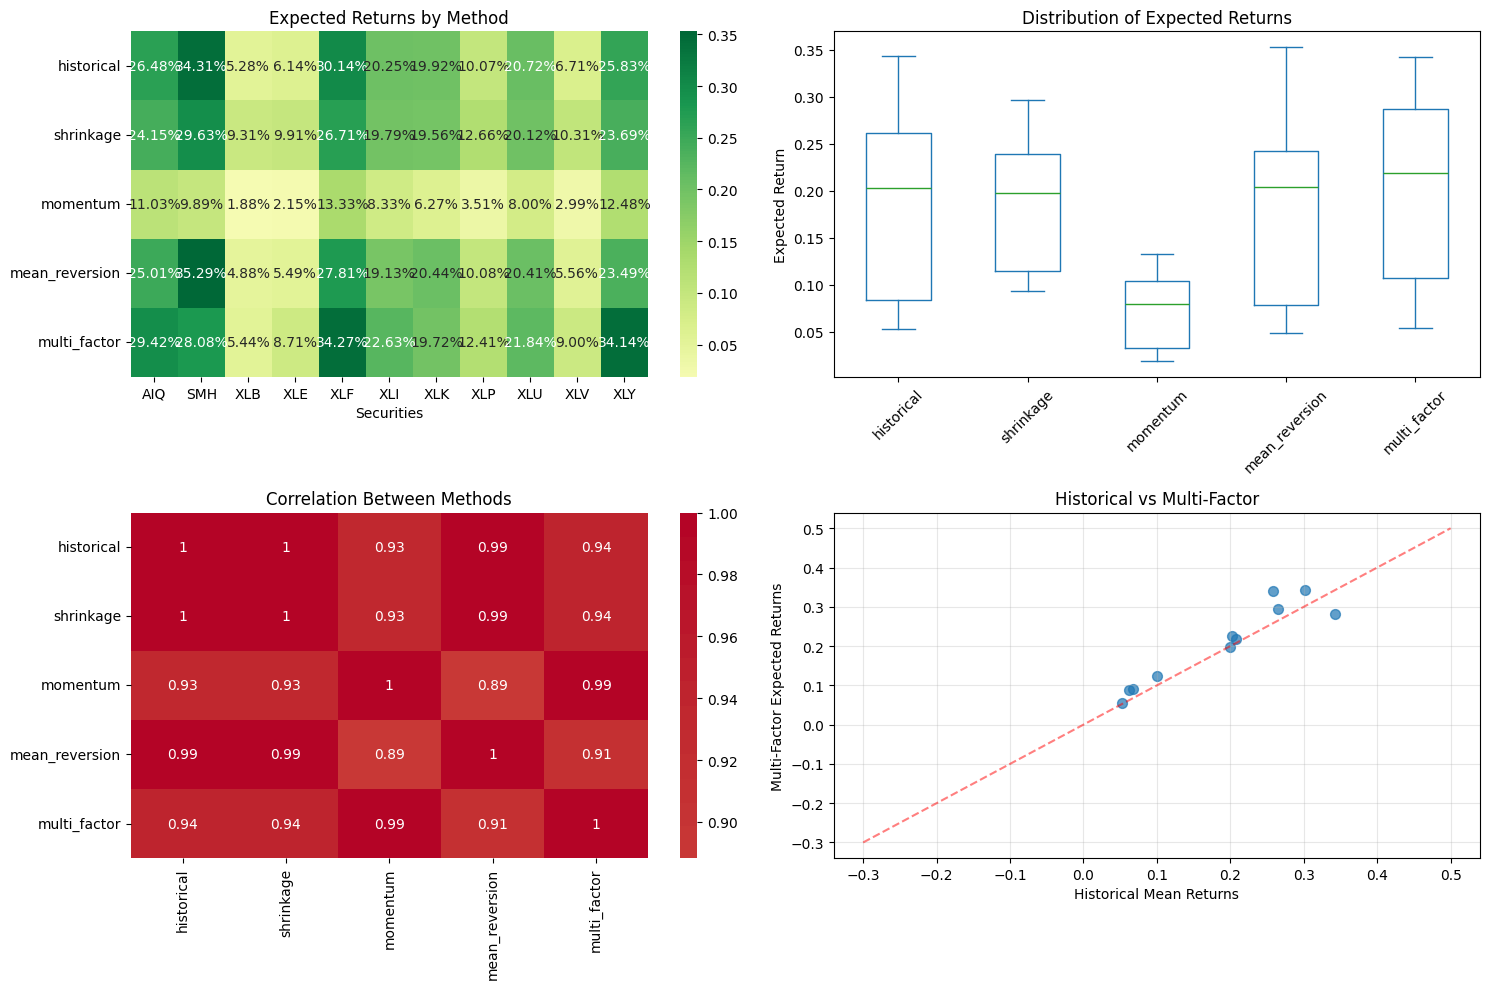


Best performing method: momentum
Preparing data for next month prediction...
Monthly dataset shape: (132, 19)
Using 9 features
Training set: 105 samples
Test set: 27 samples
Target distribution in training: {1.0: 101, 0.0: 4}
Starting hyperparameter tuning...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
Cross-validation AUC: nan
Test AUC: nan

Test Set Classification Report:
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        27

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27


Test Set Confusion Matrix:
[[27]]

Top 9 Most Important Features:
                      feature  importance
8            rolling_60d_corr      0.2854
0           mom_change_

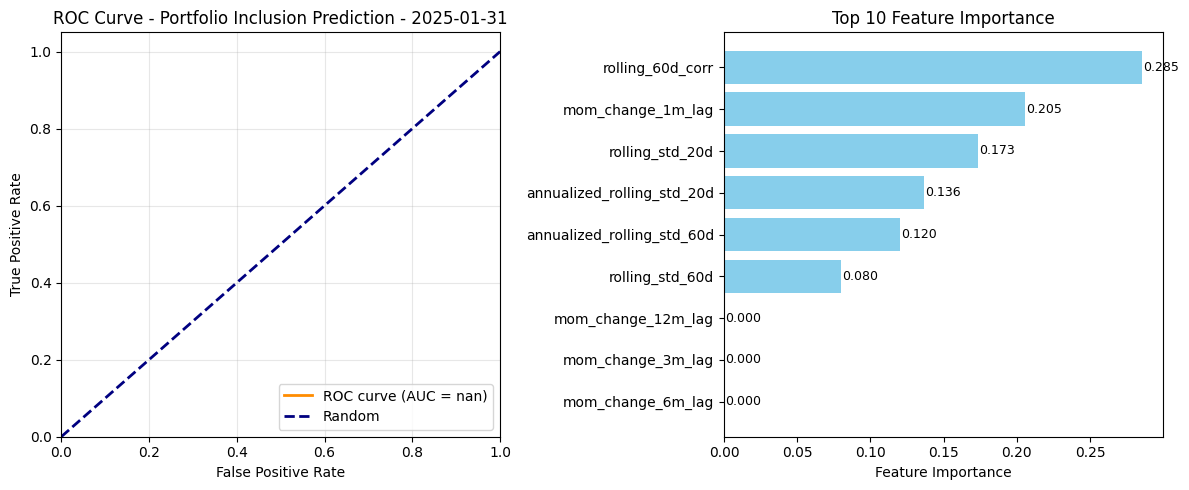


🔍 XGBoost Prediction Results for 2025-01-31:
Total securities evaluated: 11
  security current_month  predicted_include_next_month  inclusion_probability
0      XLB       2025-01                             1                 0.9970
1      XLI       2025-01                             1                 0.9970
2      XLV       2025-01                             1                 0.9946
3      XLF       2025-01                             1                 0.9920
4      XLY       2025-01                             1                 0.9792
5      XLE       2025-01                             1                 0.9743
6      AIQ       2025-01                             1                 0.9734
7      SMH       2025-01                             1                 0.9734
8      XLK       2025-01                             1                 0.9734
9      XLU       2025-01                             1                 0.9734
Portfolio for 2024-12:
  - Securities to include: 11
  - Top 5 pr

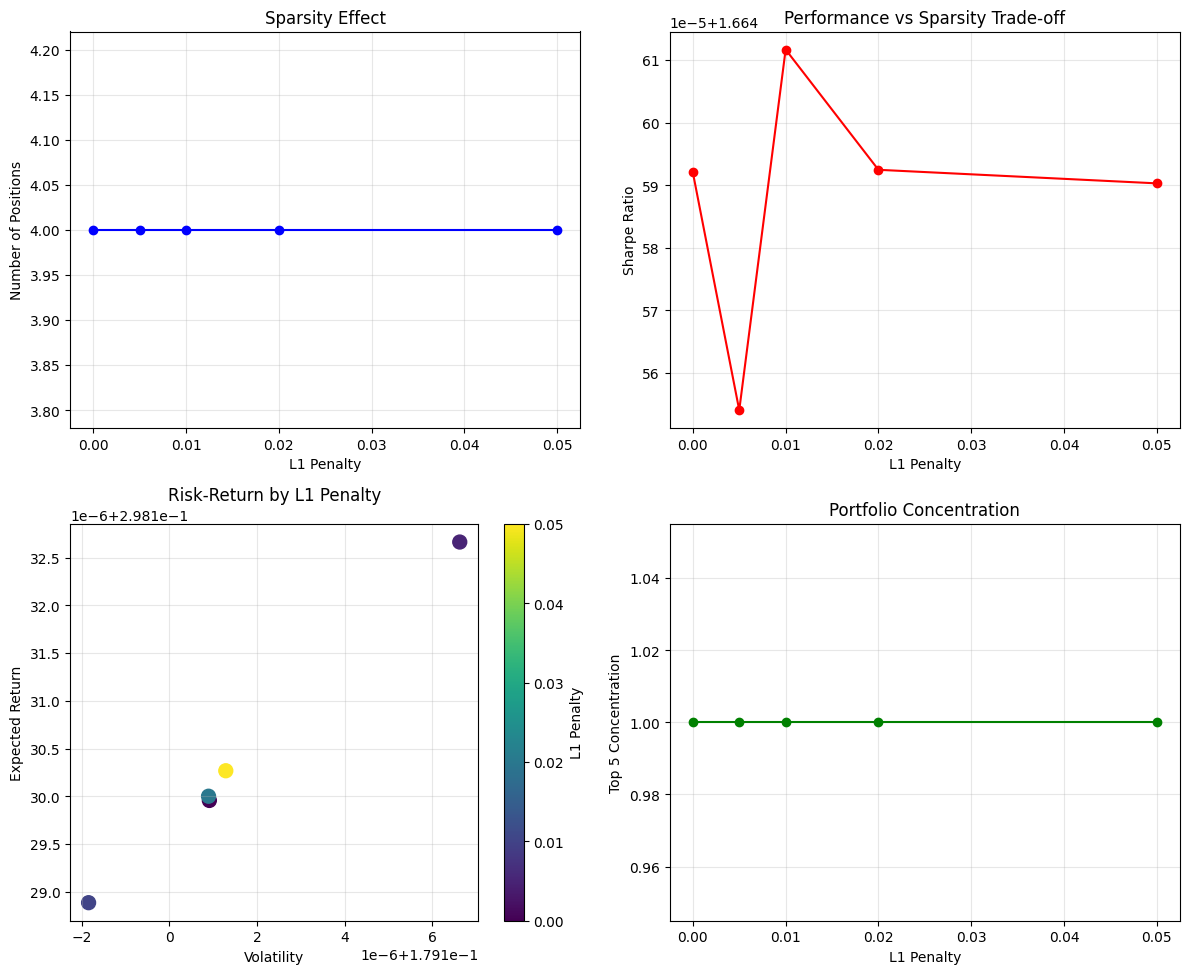


Regularization Comparison:
   L1_Penalty  Return  Volatility  Sharpe  Num_Positions  Max_Weight  \
0      0.0000  0.2981      0.1791  1.6646              4      0.3000   
1      0.0050  0.2981      0.1791  1.6646              4      0.3000   
2      0.0100  0.2981      0.1791  1.6646              4      0.3000   
3      0.0200  0.2981      0.1791  1.6646              4      0.3000   
4      0.0500  0.2981      0.1791  1.6646              4      0.3000   

   Top5_Concentration   Status  
0              1.0000  optimal  
1              1.0000  optimal  
2              1.0000  optimal  
3              1.0000  optimal  
4              1.0000  optimal  
Stored results for 2025-01-31 00:00:00: 4 positions, Expected Return: 11.43%
📊 Debug benchmark returns:
   Type: <class 'pandas.core.series.Series'>
   Shape: (20,)
   Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
   First few values: Date
2025-01-02   0.0051
2025-01-03   0.0156
2025-01-06   0.0030
Name: bm_ln_change, d

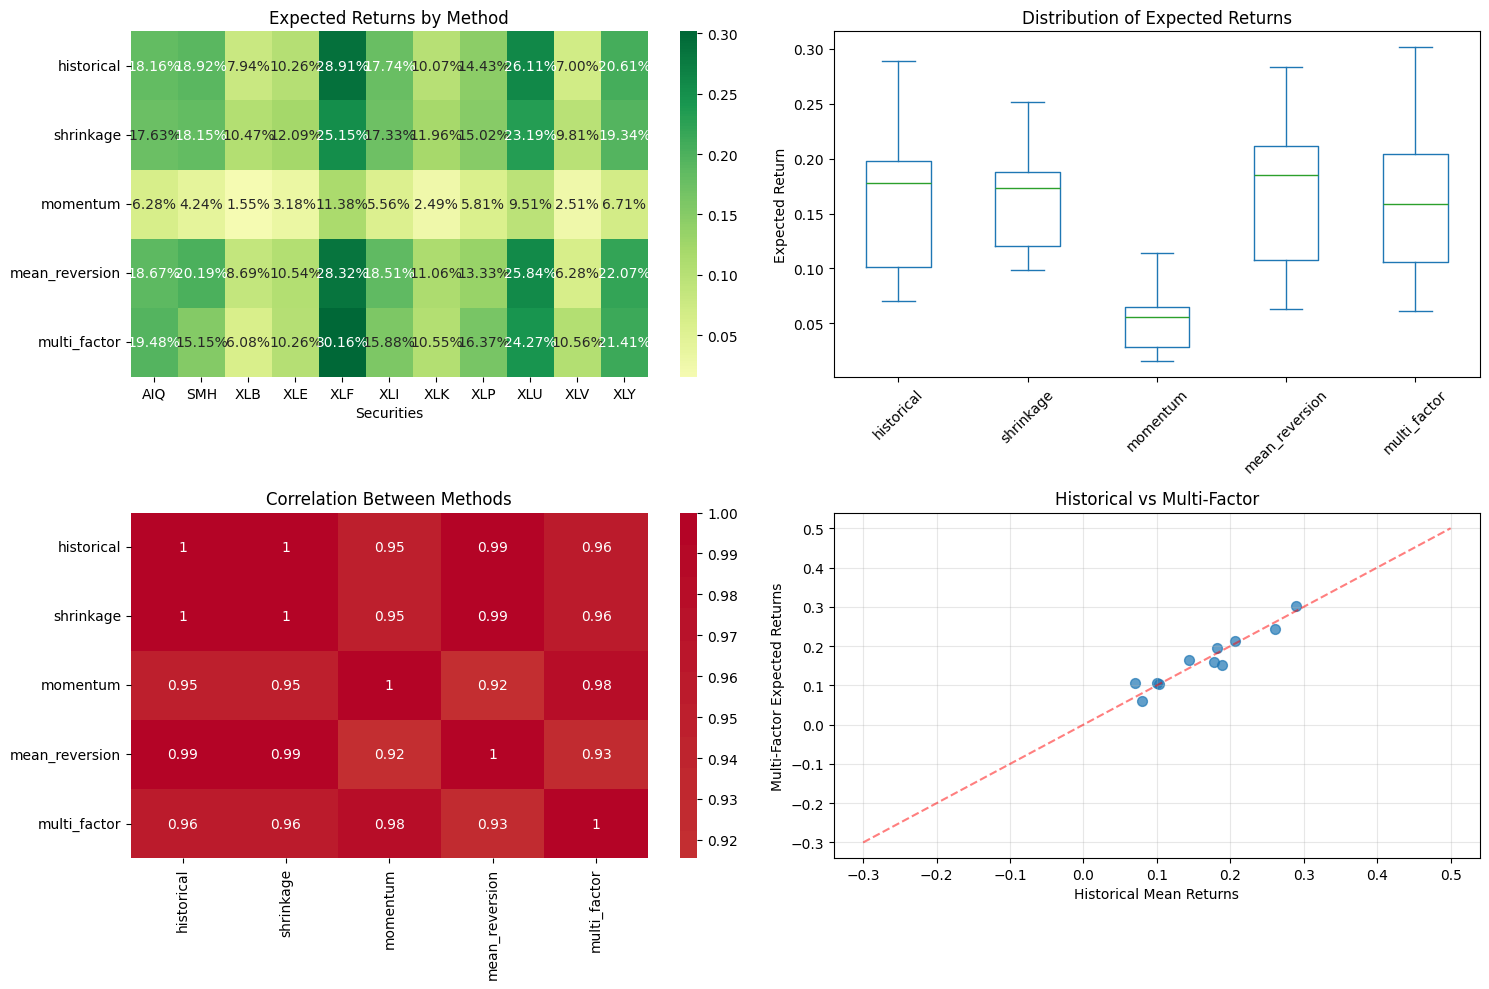


Best performing method: momentum
Preparing data for next month prediction...
Monthly dataset shape: (143, 19)
Using 9 features
Training set: 114 samples
Test set: 29 samples
Target distribution in training: {1.0: 110, 0.0: 4}
Starting hyperparameter tuning...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
Cross-validation AUC: nan
Test AUC: nan

Test Set Classification Report:
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        29

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29


Test Set Confusion Matrix:
[[29]]

Top 9 Most Important Features:
                      feature  importance
8            rolling_60d_corr      0.2080
1           mom_change_

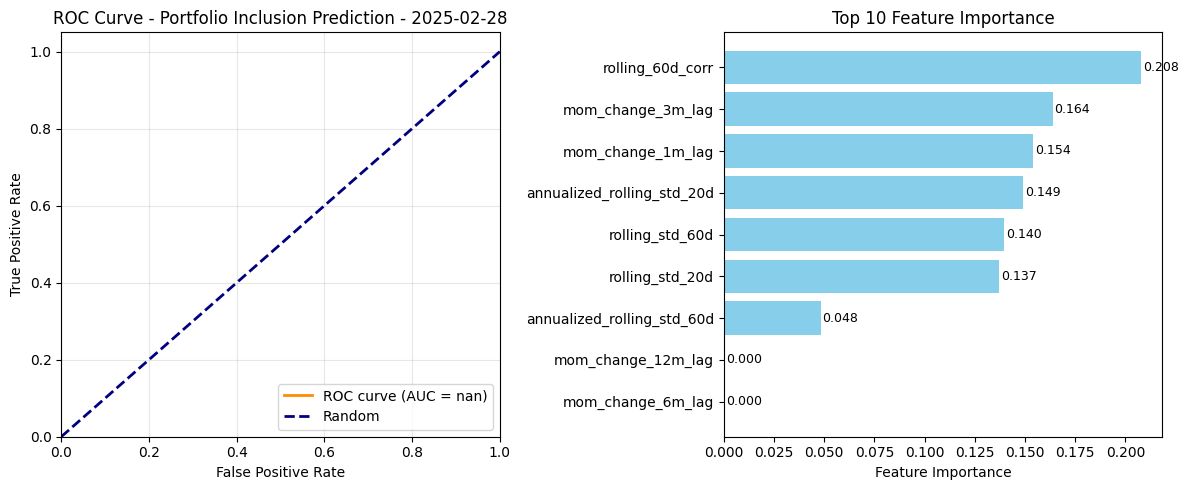


🔍 XGBoost Prediction Results for 2025-02-28:
Total securities evaluated: 11
  security current_month  predicted_include_next_month  inclusion_probability
0      XLF       2025-02                             1                 0.9937
1      XLI       2025-02                             1                 0.9934
2      XLB       2025-02                             1                 0.9917
3      XLU       2025-02                             1                 0.9896
4      XLY       2025-02                             1                 0.9866
5      AIQ       2025-02                             1                 0.9804
6      SMH       2025-02                             1                 0.9783
7      XLE       2025-02                             1                 0.9719
8      XLK       2025-02                             1                 0.9705
9      XLV       2025-02                             1                 0.9478
Portfolio for 2025-01:
  - Securities to include: 11
  - Top 5 pr

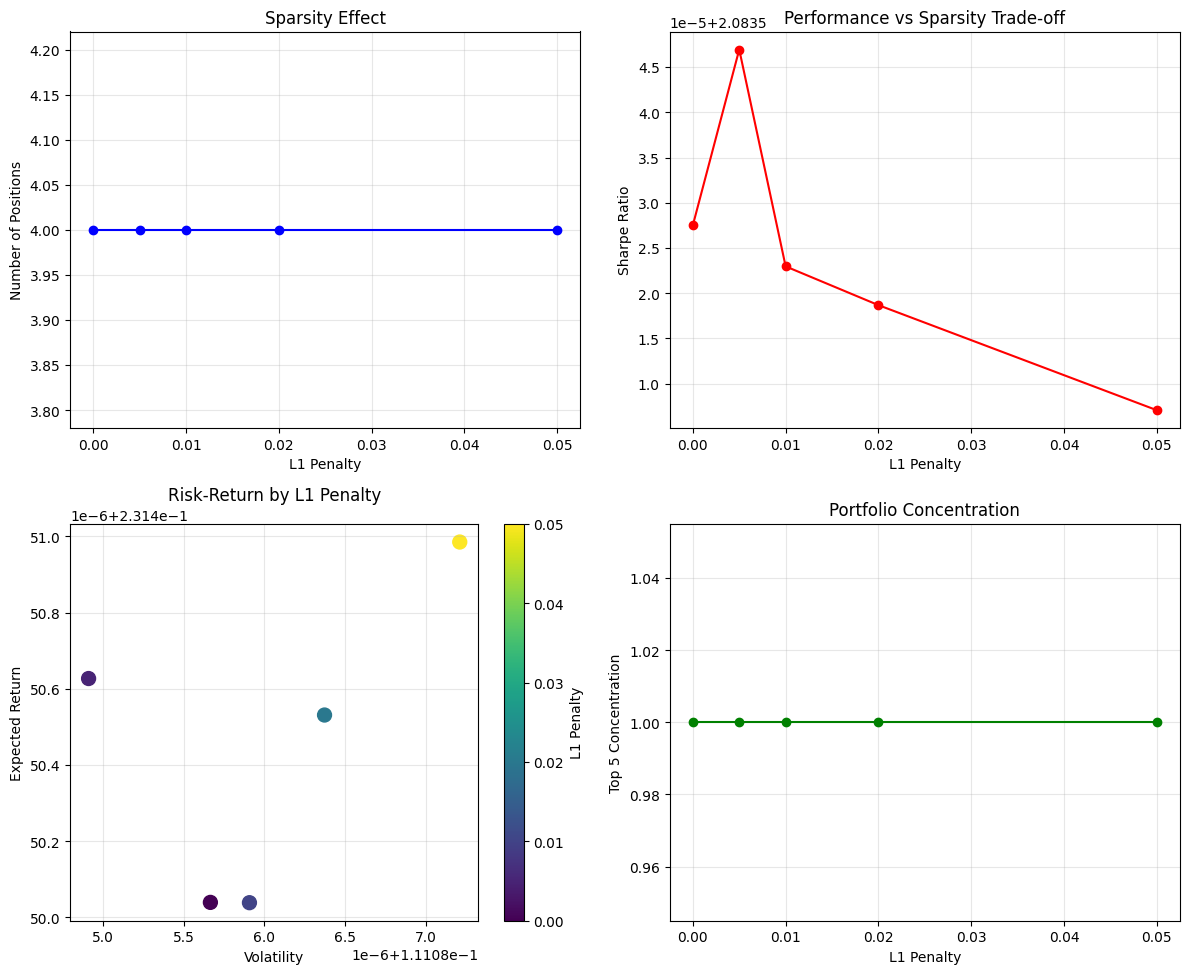


Regularization Comparison:
   L1_Penalty  Return  Volatility  Sharpe  Num_Positions  Max_Weight  \
0      0.0000  0.2315      0.1111  2.0835              4      0.3000   
1      0.0050  0.2315      0.1111  2.0835              4      0.3000   
2      0.0100  0.2315      0.1111  2.0835              4      0.3000   
3      0.0200  0.2315      0.1111  2.0835              4      0.3000   
4      0.0500  0.2315      0.1111  2.0835              4      0.3000   

   Top5_Concentration   Status  
0              1.0000  optimal  
1              1.0000  optimal  
2              1.0000  optimal  
3              1.0000  optimal  
4              1.0000  optimal  
Stored results for 2025-02-28 00:00:00: 4 positions, Expected Return: 7.61%
📊 Debug benchmark returns:
   Type: <class 'pandas.core.series.Series'>
   Shape: (19,)
   Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
   First few values: Date
2025-02-03   -0.0003
2025-02-04    0.0059
2025-02-05    0.0155
Name: bm_ln_change,

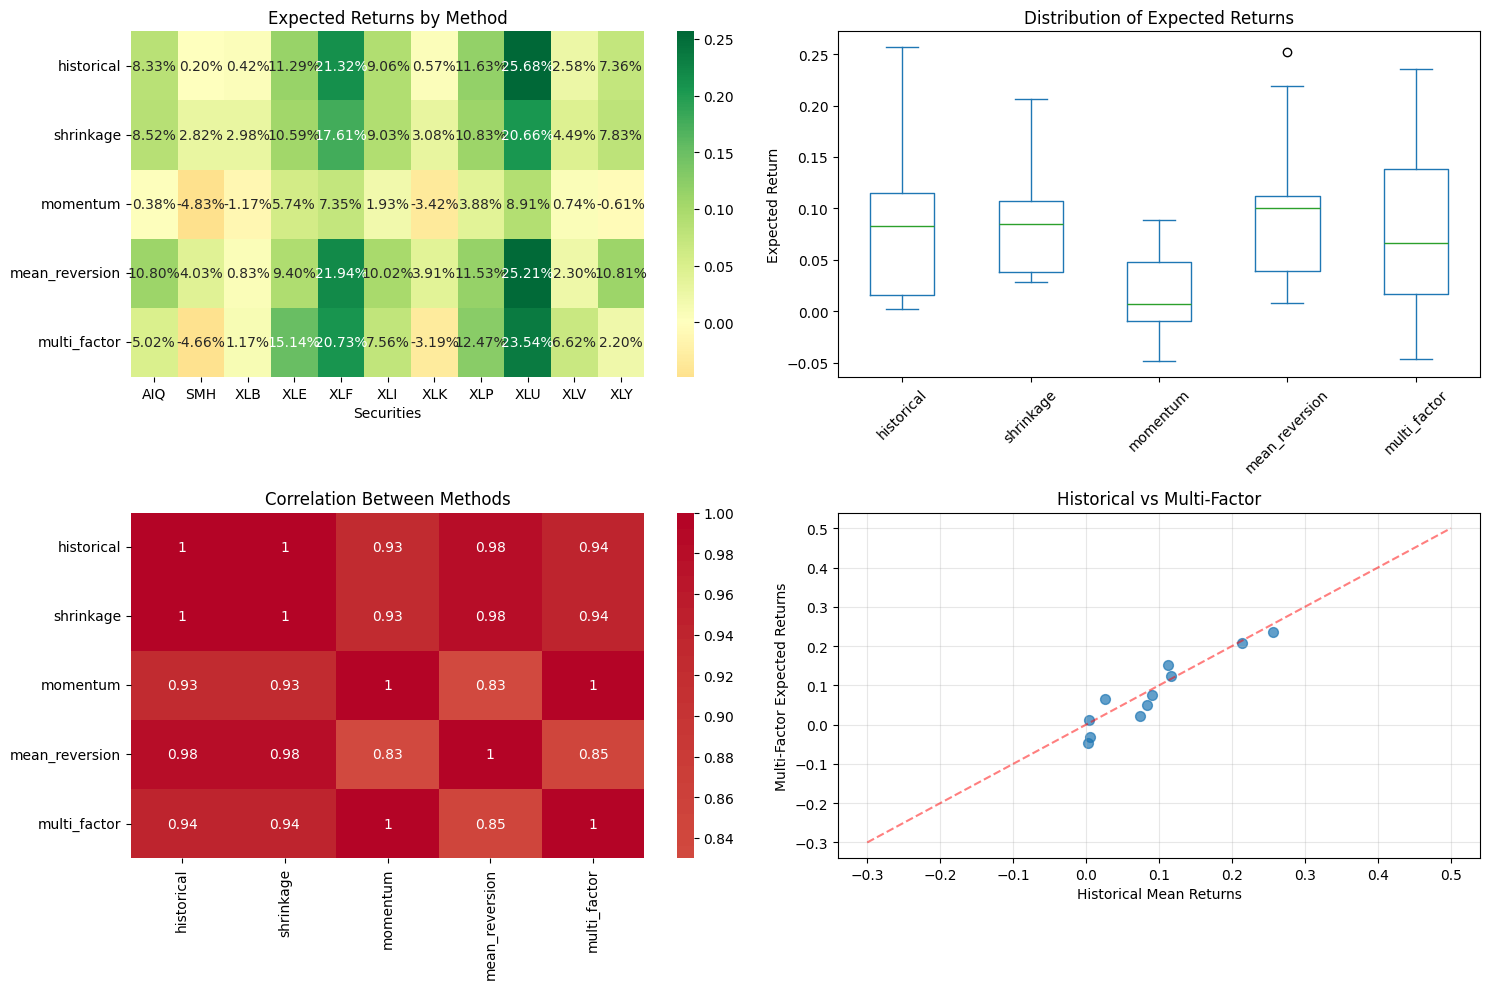


Best performing method: multi_factor
Preparing data for next month prediction...
Monthly dataset shape: (143, 19)
Using 9 features
Training set: 114 samples
Test set: 29 samples
Target distribution in training: {1.0: 109, 0.0: 5}
Starting hyperparameter tuning...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
Cross-validation AUC: nan
Test AUC: 0.6389

Test Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.93      1.00      0.96        27

    accuracy                           0.93        29
   macro avg       0.47      0.50      0.48        29
weighted avg       0.87      0.93      0.90        29


Test Set Confusion Matrix:
[[ 0  2]
 [ 0 27]]

Top 9 Most Important Features:
                      feature  imp

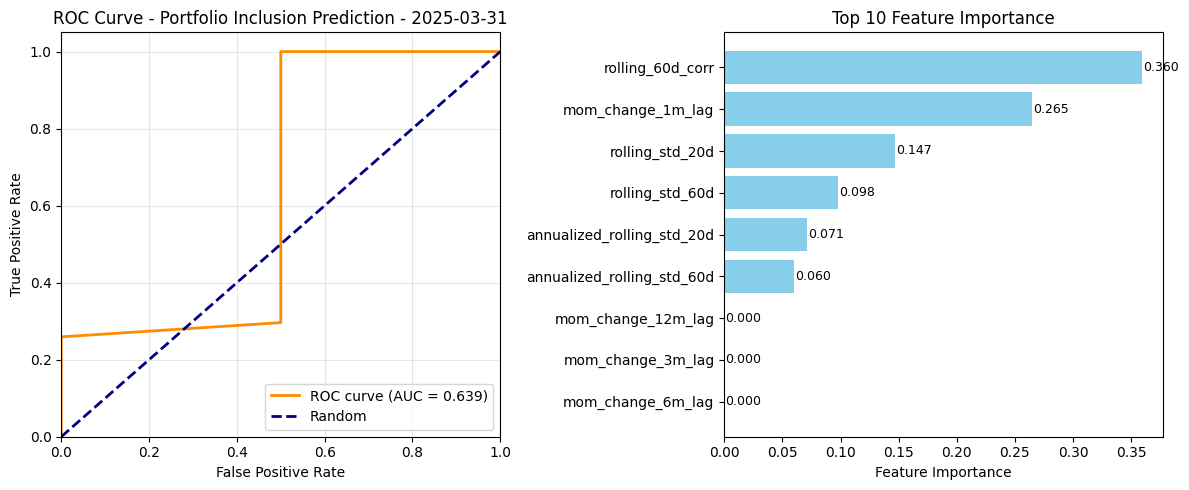


🔍 XGBoost Prediction Results for 2025-03-31:
Total securities evaluated: 11
  security current_month  predicted_include_next_month  inclusion_probability
0      XLU       2025-03                             1                 0.9875
1      XLF       2025-03                             1                 0.9875
2      XLE       2025-03                             1                 0.9875
3      XLI       2025-03                             1                 0.9856
4      XLB       2025-03                             1                 0.9855
5      SMH       2025-03                             1                 0.9848
6      AIQ       2025-03                             1                 0.9848
7      XLK       2025-03                             1                 0.9848
8      XLY       2025-03                             1                 0.9848
9      XLV       2025-03                             1                 0.9726
Portfolio for 2025-02:
  - Securities to include: 11
  - Top 5 pr

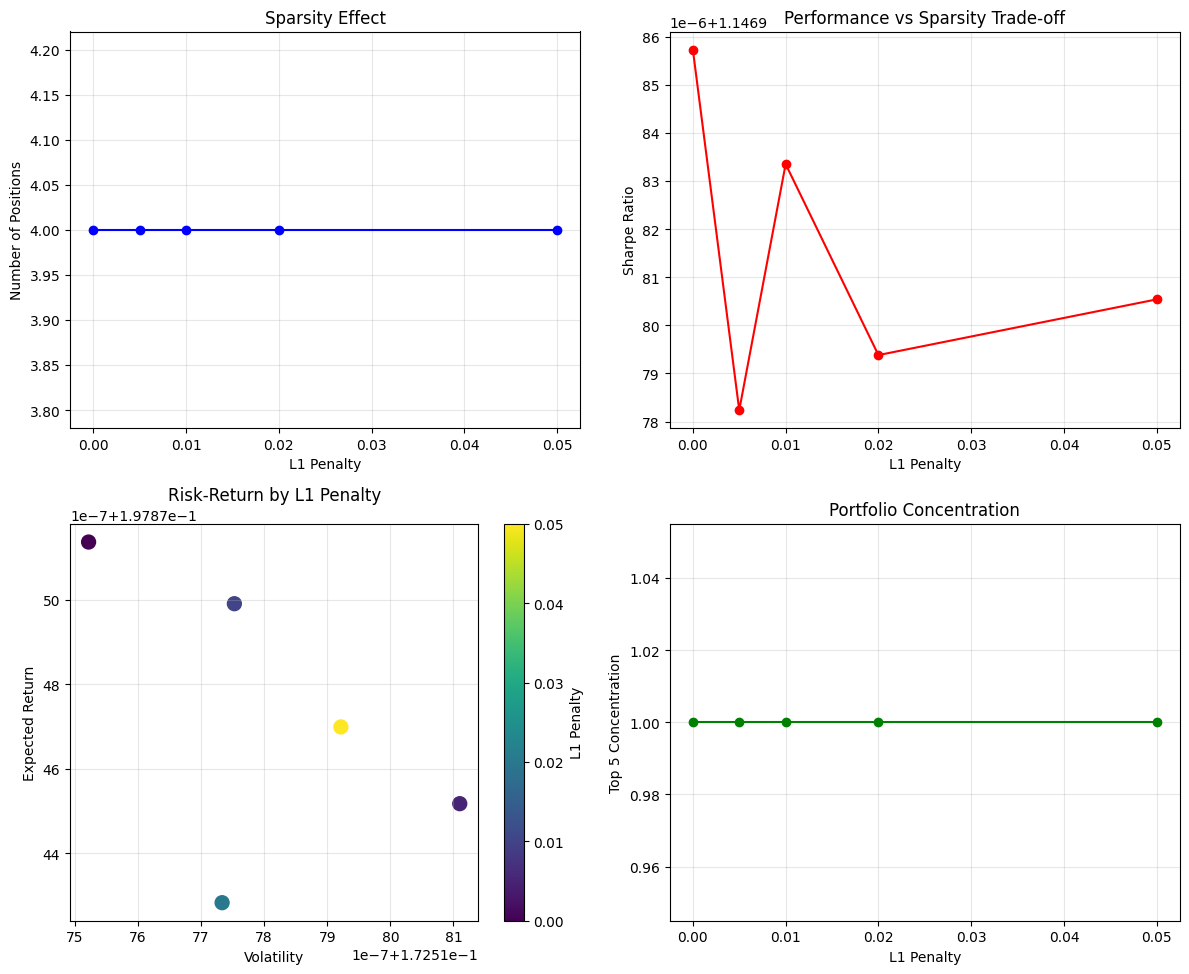


Regularization Comparison:
   L1_Penalty  Return  Volatility  Sharpe  Num_Positions  Max_Weight  \
0      0.0000  0.1979      0.1725  1.1470              4      0.3000   
1      0.0050  0.1979      0.1725  1.1470              4      0.3000   
2      0.0100  0.1979      0.1725  1.1470              4      0.3000   
3      0.0200  0.1979      0.1725  1.1470              4      0.3000   
4      0.0500  0.1979      0.1725  1.1470              4      0.3000   

   Top5_Concentration   Status  
0              1.0000  optimal  
1              1.0000  optimal  
2              1.0000  optimal  
3              1.0000  optimal  
4              1.0000  optimal  
Stored results for 2025-03-31 00:00:00: 4 positions, Expected Return: 17.54%
📊 Debug benchmark returns:
   Type: <class 'pandas.core.series.Series'>
   Shape: (21,)
   Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
   First few values: Date
2025-03-03   -0.0189
2025-03-04   -0.0208
2025-03-05    0.0127
Name: bm_ln_change

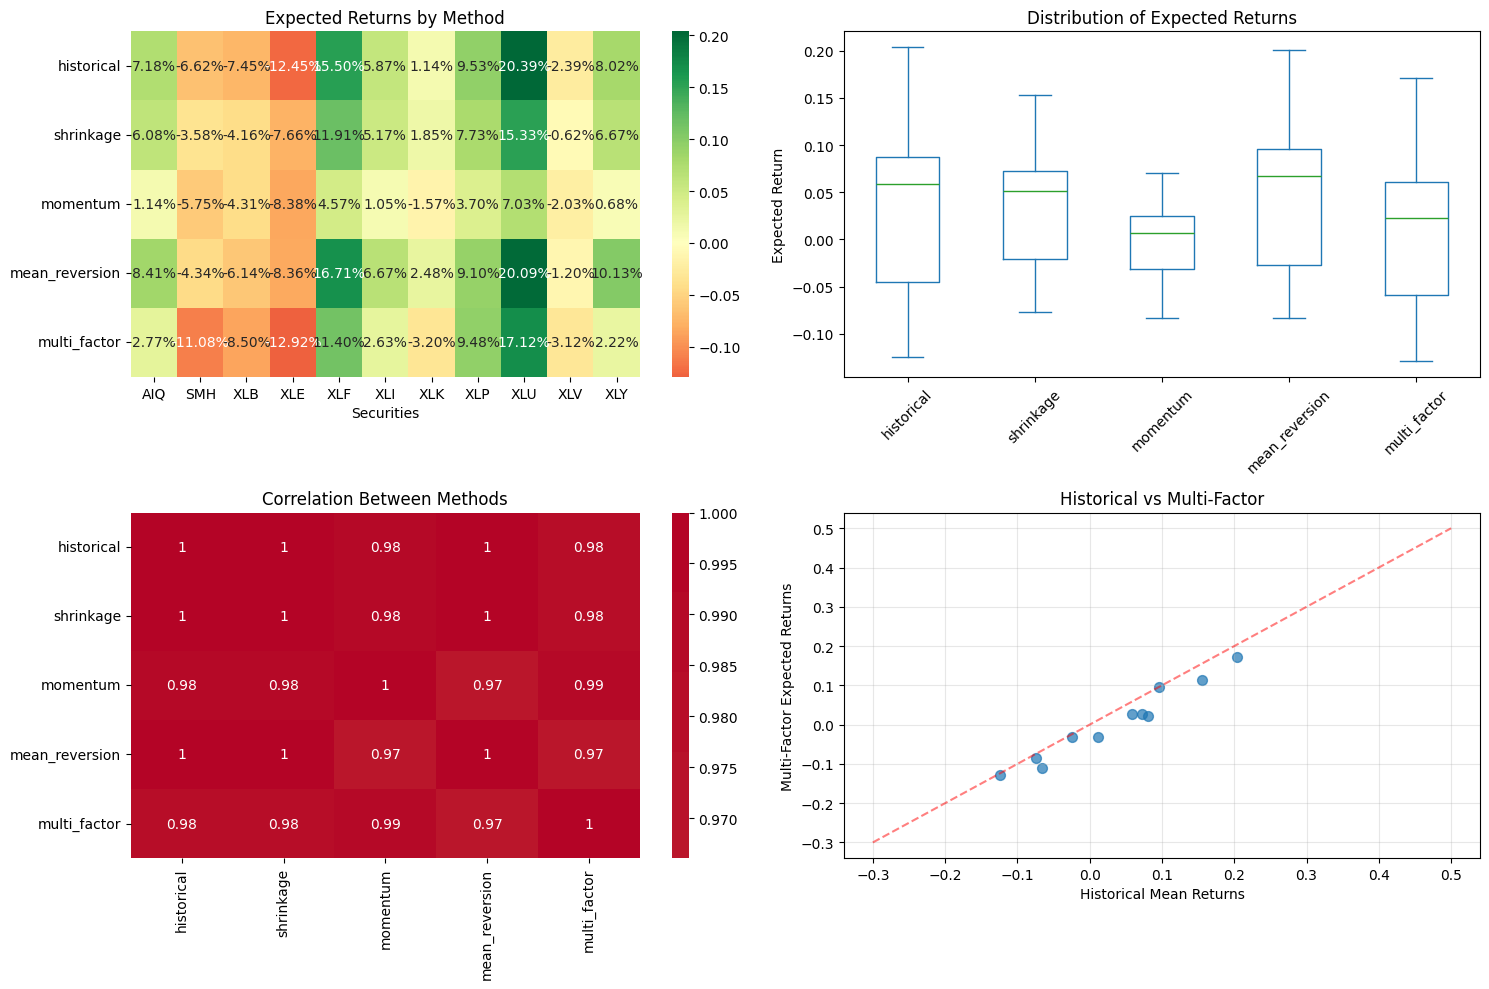


Best performing method: momentum
Preparing data for next month prediction...
Monthly dataset shape: (132, 19)
Using 9 features
Training set: 105 samples
Test set: 27 samples
Target distribution in training: {1.0: 105}
Starting hyperparameter tuning...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits

❌ Error processing 2025-04-30: 
All the 1296 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1296 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\johnd\nysif_jd_assignment2\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\johnd\nysif_jd_assignment2\.venv\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return f

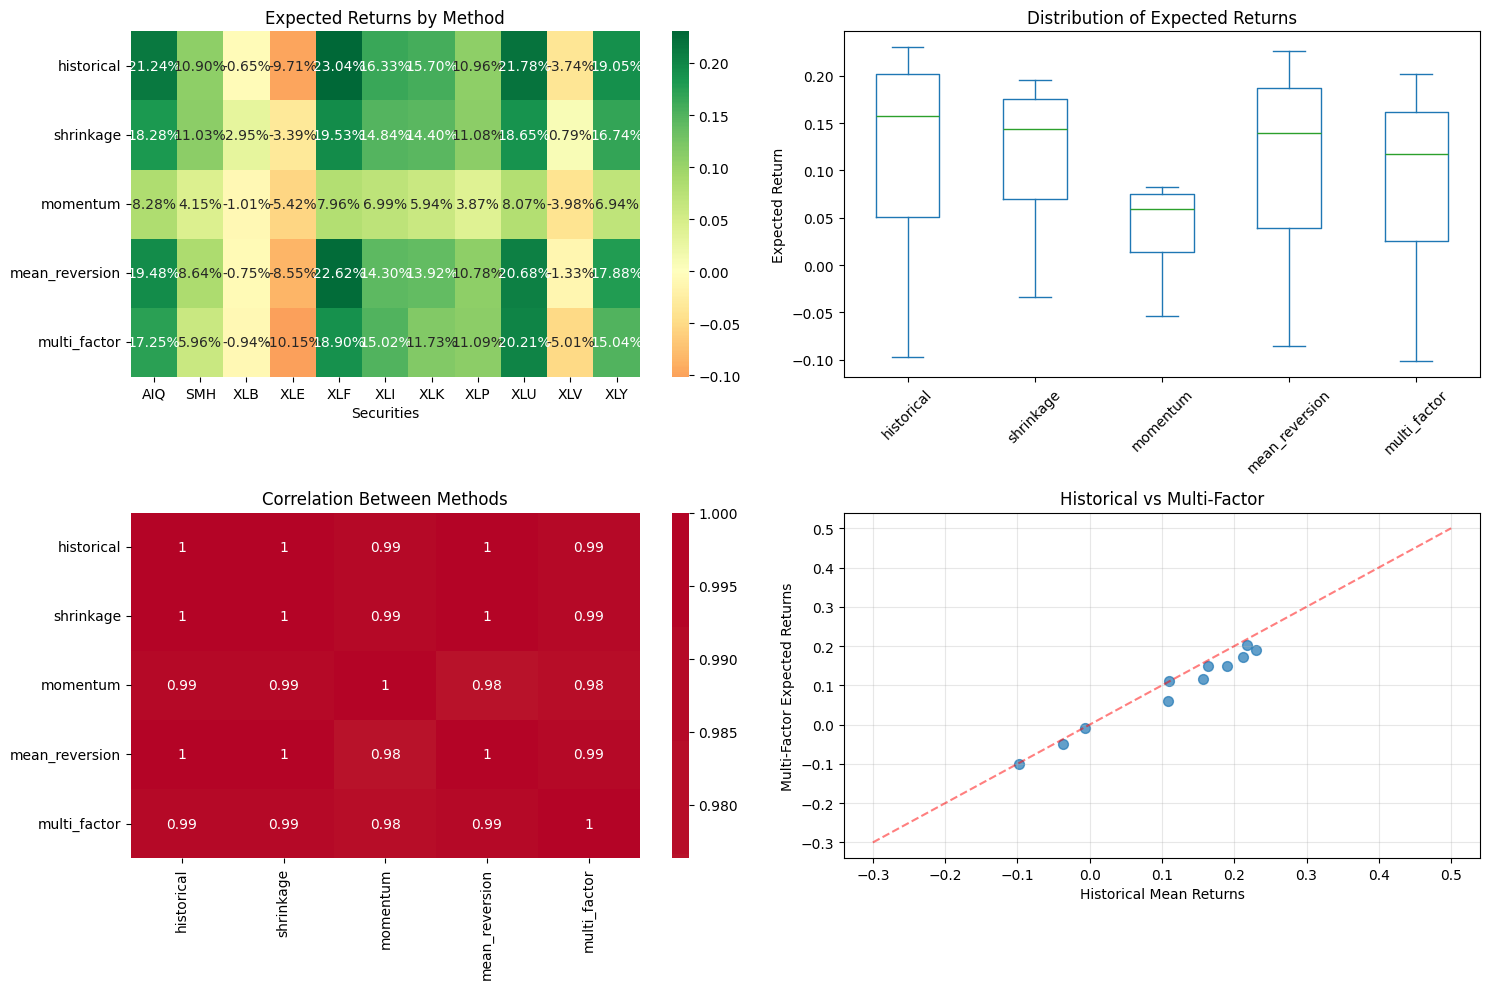


Best performing method: multi_factor
Preparing data for next month prediction...
Monthly dataset shape: (143, 19)
Using 9 features
Training set: 114 samples
Test set: 29 samples
Target distribution in training: {1.0: 114}
Starting hyperparameter tuning...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits

❌ Error processing 2025-05-31: 
All the 1296 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1296 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\johnd\nysif_jd_assignment2\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\johnd\nysif_jd_assignment2\.venv\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    retu

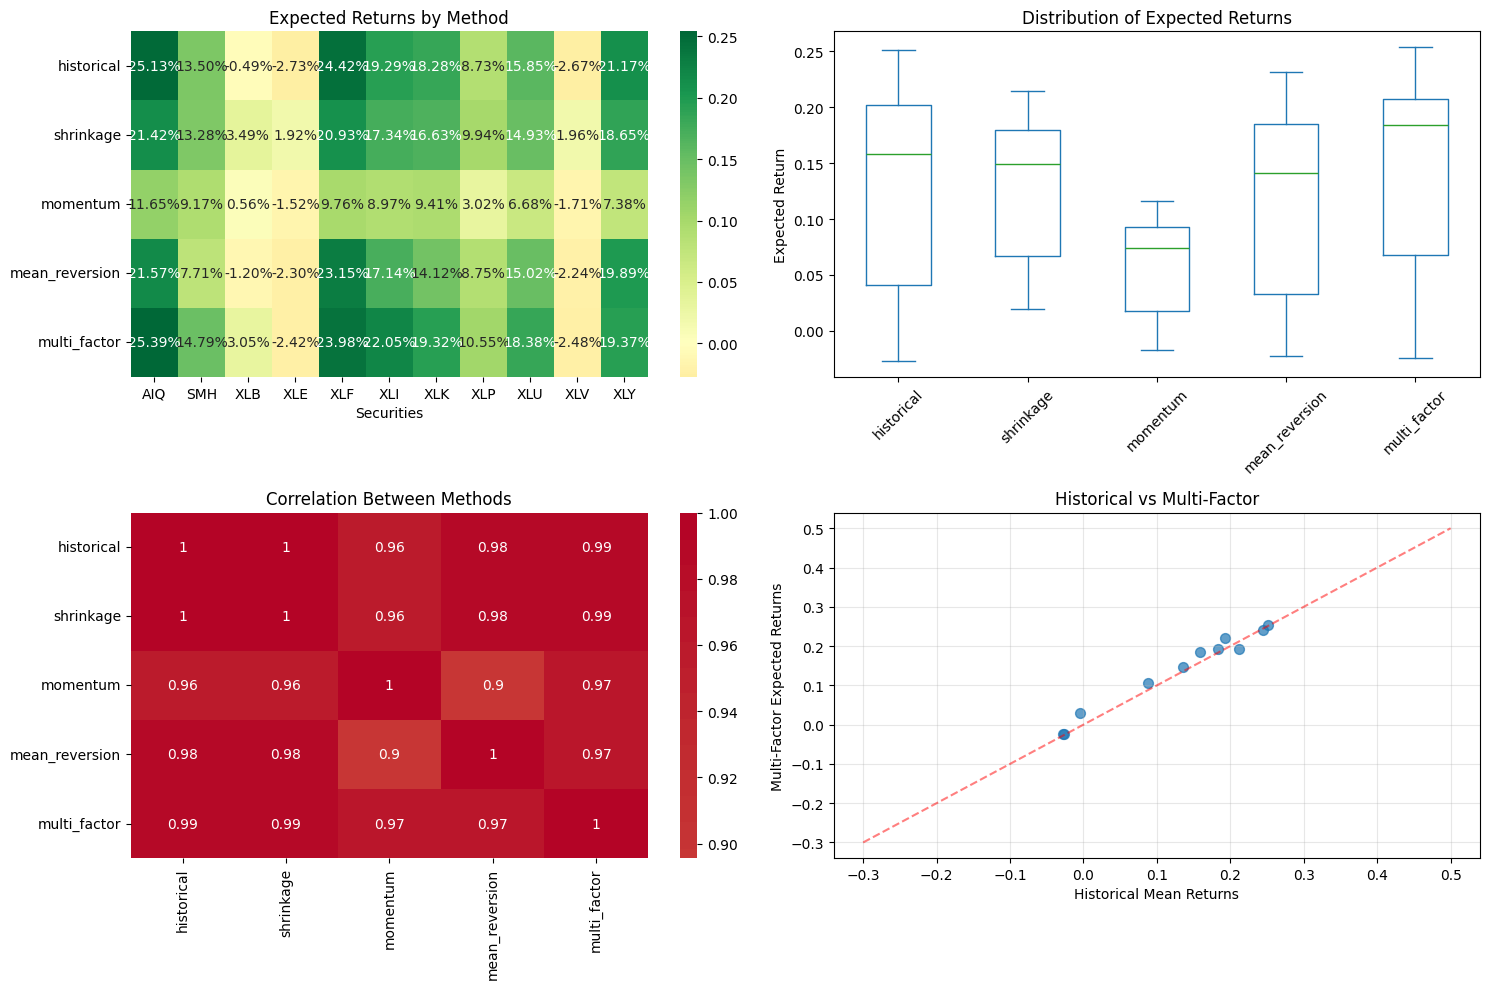


Best performing method: historical
Preparing data for next month prediction...
Monthly dataset shape: (143, 19)
Using 9 features
Training set: 114 samples
Test set: 29 samples
Target distribution in training: {1.0: 114}
Starting hyperparameter tuning...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits

❌ Error processing 2025-06-30: 
All the 1296 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1296 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\johnd\nysif_jd_assignment2\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\johnd\nysif_jd_assignment2\.venv\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return

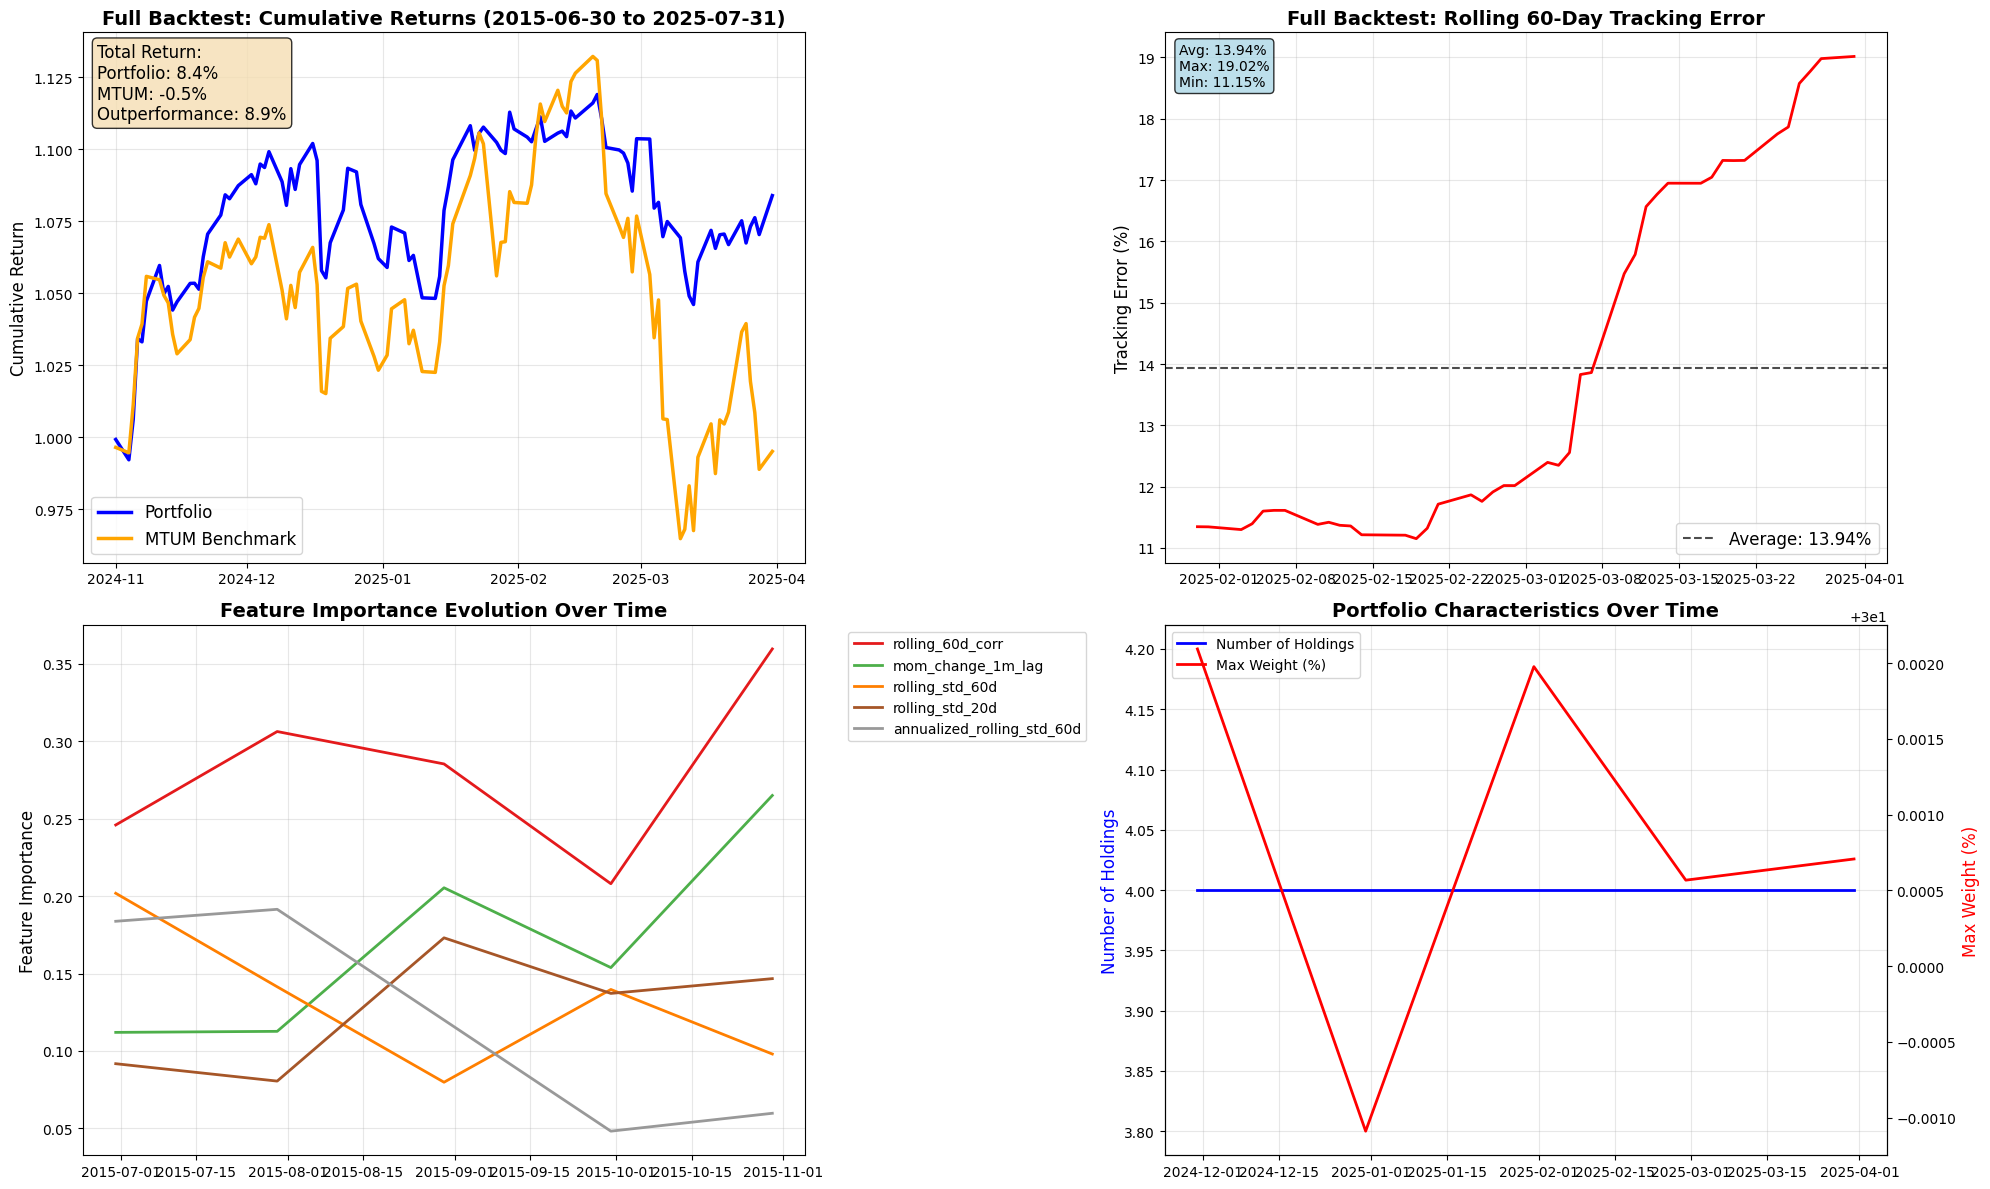

Total months processed: 2
Successful optimizations: -1
Failed optimizations: 3
Success rate: -50.0%

Failed months:
  2025-04-30: Exception: 
All the 1296 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1296 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\johnd\nysif_jd_assignment2\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\johnd\nysif_jd_assignment2\.venv\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\johnd\nysif_jd_assignment2\.venv\Lib\site-packages\xgboost\sklearn.py", line 1641, in fit
    raise ValueError(
ValueError: Invalid classes inferred fr

In [26]:
predicted_portfolio = {}
backtest_results_date_dict = {}

# Add this to your monthly loop initialization:
monthly_weights_history = []
# Initialize at the beginning (with other initializations):
feature_importance_history = []

##############################################################################################################################################################################
trading_days_per_year = 252

# Initialize weight state management outside the loop
previous_weights = None
current_weights = None
failed_optimizations = []

# Initialize main backtest storage for the entire period
main_backtest_storage = BacktestResultsStorage(
    start_date=str(new_month_end_dates[START_INDEX]), 
    end_date=str(new_month_end_dates[END_INDEX]), 
    benchmark_name='MTUM'
)

print(f"Initialized backtest storage for {len(new_month_end_dates)} months")
print(f"Period: {new_month_end_dates[START_INDEX]} to {new_month_end_dates[END_INDEX]}")

###############################################################################################################################################################################
# BULK MODE CONFIGURATION - 
###############################################################################################################################################################################

# Configuration flags for bulk processing
BULK_MODE = False                      # Enable bulk mode for 123 months
SAVE_MONTHLY_CHARTS = False            # Skip individual monthly charts
SAVE_EXPECTED_RETURNS_PLOTS = False    # Skip expected returns plots
SAVE_FEATURE_IMPORTANCE = False        # Skip feature importance charts
SAVE_DETAILED_METRICS = False          # Skip detailed transaction analysis
CHECKPOINT_EVERY_N_MONTHS = 24         # Save checkpoint every 24 months
MINIMAL_LOGGING = True                 # Reduce verbose output

if BULK_MODE:
    print(f"🚀 BULK MODE ENABLED")
    print(f"   - Monthly charts: {'OFF' if not SAVE_MONTHLY_CHARTS else 'ON'}")
    print(f"   - Expected returns plots: {'OFF' if not SAVE_EXPECTED_RETURNS_PLOTS else 'ON'}")
    print(f"   - Feature importance charts: {'OFF' if not SAVE_FEATURE_IMPORTANCE else 'ON'}")
    print(f"   - Checkpoints every: {CHECKPOINT_EVERY_N_MONTHS} months")
    print(f"   - Processing {len(new_month_end_dates)} months total")

###############################################################################################################################################################################

###############################################################################################################################################################################

def get_last_month_data(df):
    # Ensure the 'Date' level of the MultiIndex is in datetime format
    dates = pd.to_datetime(df.index.get_level_values('Date'))
    
    # Get the last date in the entire dataset
    last_date = dates.max()
    
    # Get the last month and year
    last_month_year = pd.Period(last_date, 'M')
    
    # Filter the DataFrame for the last month
    # This checks if the month and year of each date matches the last month's period
    last_month_data = df[dates.to_period('M') == last_month_year]
    
    return last_month_data

def safe_transaction_costs(old_weights, new_weights, cost_per_trade_bps=5.0):
    """Safe transaction cost calculation that handles None/empty weights"""
    try:
        return calculate_transaction_costs(old_weights, new_weights, cost_per_trade_bps)
    except Exception as e:
        print(f"   ⚠️  Transaction cost calculation error: {str(e)}")
        return {
            'total_turnover': 0,
            'transaction_costs': 0,
            'cost_bps': cost_per_trade_bps,
            'num_trades': 0,
            'new_positions': 0 if new_weights is None else len(new_weights),
            'closed_positions': 0
        }

def update_weight_state(new_optimal_weights):
    """Safely update weight state for next iteration"""
    global previous_weights, current_weights
    
    if new_optimal_weights is not None and not new_optimal_weights.empty:
        previous_weights = new_optimal_weights.copy()
        current_weights = new_optimal_weights.copy()
        print(f"   ✅ Updated weight state: {len(new_optimal_weights)} positions")
        return True
    else:
        print(f"   ⚠️  Warning: Not updating weight state due to empty/invalid weights")
        return False

# Main loop through monthly dates
for loop_index, d in enumerate(new_month_end_dates[START_INDEX:END_INDEX]):  # Your original loop range
    
    print(f"\n{'='*80}")
    print(f"PROCESSING MONTH {loop_index + 1}/{len(new_month_end_dates[1:3])}: {d}")
    print(f"{'='*80}")
    
    try:
        ## Setup to Get 13 Months of Data - our Analysis runs on a 13 month look back window. ( the 12 month momentum )
        print(f"Running {d}")
        start_date = pd.to_datetime(d) - pd.DateOffset(months=13)
        end_date = pd.to_datetime(d)
        print(f"Analysis Start Date: {start_date} : Analysis End Date: {end_date}")

        ###############################################################################################################################################################################
        # 1-17.) Your existing data processing pipeline (unchanged)
        ###############################################################################################################################################################################
        
        # 1.) Get Adj_Close from Portfolio Data and Filter it for 13 Months of Data
        stage_1_portfolio_data = portfolio_data.groupby(['Ticker', 'Date']).agg({'Adj_Close': 'last'}).reset_index()
        stage_1_benchmark_data = benchmark_data.groupby(['Ticker', 'Date']).agg({'Adj_Close': 'last'}).reset_index()
        
        # 2.) Get Adj_Close from Benchmark Data and Filter it for 13 Months of Data  - PRECLEAN DATA to Get Rid of Invalid Tickers! 

        stage_2_portfolio_data, stage_2_benchmark_data, data_coverage_report = clean_data_pipeline_step(
            stage_1_portfolio_data=stage_1_portfolio_data,
            stage_1_benchmark_data=stage_1_benchmark_data, 
            start_date=start_date,
            end_date=end_date
        )
        
        # Check if we have enough data to proceed
        if stage_2_portfolio_data['Ticker'].nunique() < 3:
            print(f"❌ Insufficient tickers ({stage_2_portfolio_data['Ticker'].nunique()}) for analysis in {d}")
            failed_optimizations.append({'date': d, 'reason': 'Insufficient tickers after data cleaning'})
            continue
        
        print(f"✅ Data cleaning complete. Proceeding with {stage_2_portfolio_data['Ticker'].nunique()} tickers.")
        
        # 3.) Calculate Log Returns for Portfolio and Benchmark
        stage_2_portfolio_data['ln_change'] = stage_2_portfolio_data.groupby('Ticker')['Adj_Close'].transform(lambda s: np.log(s / s.shift(1))).fillna(0)
        stage_2_benchmark_data['bm_ln_change'] = stage_2_benchmark_data['Adj_Close'].transform(lambda s: np.log(s / s.shift(1))).fillna(0)
        
        # 4.) Merge the Portfolio Log Returns and Benchmark Log Returns
        stage_3_portfolio_data = pd.merge(stage_2_portfolio_data, stage_2_benchmark_data[['Date','bm_ln_change']], on=['Date'], how='left')
        stage_3_portfolio_data['ln_change_differences'] = stage_3_portfolio_data['ln_change'] - stage_3_portfolio_data['bm_ln_change']
        
        # 5.) Calculate Daily Data Features
        stage_3_portfolio_data['rolling_std_20d'] = stage_3_portfolio_data.groupby('Ticker')['ln_change'].rolling(window=20, min_periods=2).std().fillna(0).reset_index(level=0, drop=True)
        stage_3_portfolio_data['rolling_std_60d'] = stage_3_portfolio_data.groupby('Ticker')['ln_change'].rolling(window=60, min_periods=2).std().fillna(0).reset_index(level=0, drop=True)
        stage_3_portfolio_data['annualized_rolling_std_20d'] = stage_3_portfolio_data['rolling_std_20d'] * np.sqrt(trading_days_per_year)
        stage_3_portfolio_data['annualized_rolling_std_60d'] = stage_3_portfolio_data['rolling_std_60d'] * np.sqrt(trading_days_per_year)
        
        # 6.) Ugly Implementation of Rolling 60 Realized Correlation with the Benchmark
        stage_3_portfolio_data.set_index(['Ticker','Date'], inplace=True)

        rolling_corr_list = []
        for ticker in stage_3_portfolio_data.index.get_level_values('Ticker').unique():
            ticker_data = stage_3_portfolio_data.loc[ticker]
            rolling_correlation = ticker_data[['ln_change', 'bm_ln_change']].rolling(window=60, min_periods=2).corr().unstack().iloc[:, 0]
            rolling_correlation = rolling_correlation.rename('rolling_60d_corr')
            rolling_corr_list.append(rolling_correlation)

        rolling_corr_all = pd.concat(rolling_corr_list, keys=stage_3_portfolio_data.index.get_level_values('Ticker').unique(), names=['Ticker', 'Date'])
        stage_4_portfolio_data = stage_3_portfolio_data.merge(rolling_corr_all, left_index=True, right_index=True, how='left')

        # 7-16.) Monthly data processing (your existing code)
        monthly_stage_1_portfolio_data = stage_4_portfolio_data.copy()
        monthly_stage_2_portfolio_data = monthly_stage_1_portfolio_data.groupby(['Ticker']).resample('ME', level='Date').agg({'Adj_Close': 'last'}).reset_index(drop=False)
        
        # Monthly momentum features
        monthly_stage_2_portfolio_data['mom_change_1m_lag'] = monthly_stage_2_portfolio_data.groupby('Ticker')['Adj_Close'].transform(lambda s: np.log(s.shift(1) / s.shift(2))).fillna(0)
        monthly_stage_2_portfolio_data['mom_change_3m_lag'] = monthly_stage_2_portfolio_data.groupby('Ticker')['Adj_Close'].transform(lambda s: np.log(s.shift(1) / s.shift(4))).fillna(0)
        monthly_stage_2_portfolio_data['mom_change_6m_lag'] = monthly_stage_2_portfolio_data.groupby('Ticker')['Adj_Close'].transform(lambda s: np.log(s.shift(1) / s.shift(7))).fillna(0)
        monthly_stage_2_portfolio_data['mom_change_12m_lag'] = monthly_stage_2_portfolio_data.groupby('Ticker')['Adj_Close'].transform(lambda s: np.log(s.shift(1) / s.shift(13))).fillna(0)
        
        # Monthly tracking error
        monthly_data_annualized_tracking_error = monthly_stage_1_portfolio_data.groupby(['Ticker'])['ln_change_differences'].resample('ME', level='Date').apply(lambda s: s.std() * np.sqrt(trading_days_per_year)).rename('monthly_tracking_error').reset_index(drop=False)
        
        # Merge monthly features
        monthly_stage_3_portfolio_data = monthly_stage_2_portfolio_data.merge(monthly_data_annualized_tracking_error, on=['Ticker','Date'], how='left')
        monthly_stage_3_portfolio_data.set_index(['Ticker','Date'], inplace=True)
        
        # Big merge and cleanup
        stage_5_portfolio_data = pd.merge(stage_4_portfolio_data.reset_index(drop=False), monthly_stage_3_portfolio_data.reset_index(drop=False), on=['Ticker','Date'], how='left')
        stage_5_portfolio_data[['mom_change_1m_lag','mom_change_3m_lag','mom_change_6m_lag','mom_change_12m_lag','monthly_tracking_error']] = stage_5_portfolio_data[['mom_change_1m_lag','mom_change_3m_lag','mom_change_6m_lag','mom_change_12m_lag','monthly_tracking_error']].ffill()
        stage_5_portfolio_data.drop(columns=['Adj_Close_y'], inplace=True)
        stage_5_portfolio_data.rename(columns=({'Adj_Close_x':'Adj_Close'}), inplace=True)
        
        # Forward fill and target creation
        stage_6_portfolio_data = stage_5_portfolio_data.copy()
        stage_7_portfolio_data = stage_6_portfolio_data.copy()
        numeric_cols = ['mom_change_1m_lag', 'mom_change_3m_lag', 'mom_change_6m_lag', 'mom_change_12m_lag']
        stage_7_portfolio_data[numeric_cols] = stage_6_portfolio_data.groupby('Ticker')[numeric_cols].ffill()
        
        # Target creation
        threshold = stage_7_portfolio_data['monthly_tracking_error'].mean() + stage_7_portfolio_data['monthly_tracking_error'].std() * 1.96
        print(f"Threshold: {threshold:.4%}")
        stage_7_portfolio_data['target'] = stage_7_portfolio_data['monthly_tracking_error'].apply(lambda x: binary_classifier(x,threshold))
        
        final_portfolio_data = stage_7_portfolio_data.fillna(0)

        ###############################################################################################################################################################################
        # Expected Return Models
        ###############################################################################################################################################################################
        
        #  Prepare Returns Matrix for Processing #################
        returns_matrix = prepare_returns_matrix_safe(
                df=final_portfolio_data,
                date_col='Date',    # Check this matches your column name
                ticker_col='Ticker', # Check this matches your column name
                return_col='ln_change'  # Check this matches your column name
            )
        # 2. Define selected_securities BEFORE using any expected returns functions

        selected_securities = returns_matrix.columns.tolist()
        print(f"Using {len(selected_securities)} securities for backtesting")

        # Test with better error handling
        try:
            performance_metrics, backtest_results = backtest_expected_returns(
                returns_matrix=returns_matrix,
                forecast_horizon=21,
                test_periods=12  # Start with fewer periods for testing
            )
            
            print("\nExpected Returns Model Performance:")
            for method, metrics in performance_metrics.items():
                print(f"{method:15} | IC: {metrics['Information_Coefficient']:.3f} | "
                      f"Corr: {metrics['Correlation']:.3f} | N: {metrics['N_Securities']}")
                      
        except Exception as e:
            print(f"Error in backtesting: {e}")
            import traceback
            traceback.print_exc()

        print("Expected Returns Model Performance:")
        for method, metrics in performance_metrics.items():
            print(f"{method:15} | IC: {metrics['Information_Coefficient']:.3f} | "
                  f"Corr: {metrics['Correlation']:.3f} | RMSE: {metrics['RMSE']:.4f}")

        # Compare different methods visually ################# 
        if not BULK_MODE or SAVE_EXPECTED_RETURNS_PLOTS:
            expected_returns_comparison = plot_expected_returns_comparison(
                returns_matrix=returns_matrix,
                securities_subset=selected_securities[:15]  # Top 15 securities
            )
        else:
            if not MINIMAL_LOGGING:
                print("   📊 Skipping expected returns comparison plot (bulk mode)")


        # Use the best performing method in optimization #################
        best_method = max(performance_metrics.keys(), 
                         key=lambda x: performance_metrics[x]['Information_Coefficient'])
        print(f"\nBest performing method: {best_method}")

        ###############################################################################################################################################################################
        # XGBoost Training and Prediction
        ###############################################################################################################################################################################
        
        target_col = 'target'
        feature_cols = ['mom_change_1m_lag', 'mom_change_3m_lag', 'mom_change_6m_lag', 'mom_change_12m_lag', 
                       'rolling_std_20d', 'rolling_std_60d', 'annualized_rolling_std_20d', 'annualized_rolling_std_60d', 'rolling_60d_corr']

        # Train the model
        model, feature_importance, processed_data, y_test, y_test_prob, prediction_accuracy_dict = train_xgb_portfolio_model(
            df=final_portfolio_data,
            feature_columns=feature_cols,
            date_col='Date',
            security_col='Ticker',
            target_col='target'
        )
        # ADD THIS: Store feature importance for full period analysis
        feature_importance_history.append(feature_importance.copy() if feature_importance is not None else None)


        # Plot model performance
        if not BULK_MODE or SAVE_MONTHLY_CHARTS:
            auc_score = plot_model_performance(
                y_true=y_test,
                y_prob=y_test_prob,
                feature_importance_df=feature_importance,
                title=f"Portfolio Inclusion Prediction - {d}"
            )
        else:
            if not MINIMAL_LOGGING:
                print("   📊 Skipping model performance plot (bulk mode)")

        # Get next month predictions
        next_month_predictions = predict_next_month_portfolio(
            model=model,
            df=final_portfolio_data,
            feature_columns=feature_cols,
            date_col='Date',
            security_col='Ticker'
        )

        # Print the full prediction results
        print(f"\n🔍 XGBoost Prediction Results for {d}:")
        print(f"Total securities evaluated: {len(next_month_predictions)}")
        print(next_month_predictions.head(10))

        # Extract securities to INCLUDE
        include_securities = next_month_predictions[
            next_month_predictions['predicted_include_next_month'] == 1
        ].copy()
        # Sort by probability (highest first)
        include_securities = include_securities.sort_values('inclusion_probability', ascending=False)

        predicted_portfolio, include_securities = generate_monthly_portfolio_predictions(
            model=model,
            processed_data=processed_data,
            feature_cols=feature_cols,
            date_col='Date',
            security_col='Ticker'
        )

        # CLEAR DISPLAY of selected securities
        #print(f"\n✅ SECURITIES SELECTED FOR PORTFOLIO ({d}):")
        #print(f"Number of securities to INCLUDE: {len(include_securities)}")
        
        if len(include_securities) > 0:
            print(f"\nTop 10 Selected Securities:")
            display_securities = include_securities.head(10)
            for idx, row in display_securities.iterrows():
                print(f"  {row['security']}: {row['inclusion_probability']:.3f}")
            
            if len(include_securities) > 10:
                print(f"  ... and {len(include_securities) - 10} more securities")
            
            # Extract the security list for optimization
            selected_securities_for_optimization = include_securities['security'].tolist()
            
            print(f"\nSecurities being passed to CVXPY optimizer:")
            print(f"Count: {len(selected_securities_for_optimization)}")
            print(f"List: {selected_securities_for_optimization[:10]}...")  # Show first 10
            
        else:
            print("❌ NO SECURITIES SELECTED! XGBoost model predicted exclude for all securities.")
            failed_optimizations.append({'date': d, 'reason': 'No securities selected by XGBoost'})
            continue

        # Check if we have enough securities for optimization
        if len(selected_securities_for_optimization) < 5:
            print(f"⚠️  Warning: Only {len(selected_securities_for_optimization)} securities selected. This may not be enough for diversification.")
        

        ###############################################################################################################################################################################
        # CVXPY Portfolio Optimization
        ###############################################################################################################################################################################
        
        # First, get your securities from XGBoost model predictions

        print(f"\n🔧 Starting Portfolio Optimization for {d}")
        print(f"Input: {len(selected_securities_for_optimization)} selected securities")
        print(selected_securities_for_optimization)

        # 1. Prepare returns matrix
        #returns_matrix = prepare_returns_matrix(final_portfolio_data)
        
        # 2. Get selected securities from XGBoost (if you have predictions)
        if 'next_month_predictions' in locals():
            selected_securities = next_month_predictions[
                next_month_predictions['predicted_include_next_month'] == 1
            ]['security'].tolist()
        else:
            # Use all securities or define manually
            selected_securities = returns_matrix.columns.tolist()
            
        #print(f"Length of Selected Securities {len(selected_securities_for_optimization)}")
        #print(selected_securities_for_optimization)

        # 3. Run expected returns backtest
        performance_metrics, backtest_results = backtest_expected_returns(
            returns_matrix=returns_matrix[selected_securities_for_optimization],
            forecast_horizon=21,
            test_periods=12
        )

        # Prepare data for CVXPY optimization using the SELECTED securities
        try:
            portfolio_returns_matrix, mean_returns, cov_matrix, securities = prepare_cvxpy_data(
                df=final_portfolio_data,
                selected_securities=selected_securities_for_optimization,  # Use the XGBoost selected securities
                date_col='Date',
                security_col='Ticker',
                return_col='ln_change',
                lookback_days=252
            )
            
            print(f"✅ Successfully prepared optimization data:")
            print(f"   Returns matrix shape: {portfolio_returns_matrix.shape}")
            print(f"   Securities for optimization: {securities}")
            
        except Exception as e:
            print(f"❌ Error preparing CVXPY data: {e}")
            failed_optimizations.append({'date': d, 'reason': f'CVXPY data preparation failed: {e}'})
            continue

        # Optimization parameters
        optimization_params = {
            'risk_aversion': 1.0,
            'l1_penalty': 0.01,
            'max_weight': 0.30,
            'min_weight': 0.005,
            'max_positions': 20
        }

        # Integrate expected returns
        try:
            expected_returns, cov_matrix, securities = integrate_expected_returns_with_optimizer(
                returns_matrix=portfolio_returns_matrix,
                selected_securities=selected_securities_for_optimization,
                expected_returns_method=best_method
            )
            
            print(f"✅ Expected returns calculated using method: {best_method}")
            
        except Exception as e:
            print(f"❌ Error calculating expected returns: {e}")
            failed_optimizations.append({'date': d, 'reason': f'Expected returns calculation failed: {e}'})
            continue


        # Run the optimization
        try:
            optimal_weights, portfolio_return, portfolio_vol, sharpe_ratio, status = optimize_portfolio_cvxpy(
                mean_returns=expected_returns,
                cov_matrix=cov_matrix,
                securities=securities,
                risk_aversion=1.0,
                l1_penalty=0.01,
                max_weight=0.30,
                min_weight=0.005
            )
            
            if optimal_weights is None or optimal_weights.empty:
                print(f"❌ Optimization failed for {d}: {status}")
                failed_optimizations.append({'date': d, 'reason': f'Optimization failed: {status}'})
                continue
            
            print(f"\n🎯 OPTIMIZATION RESULTS for {d}:")
            print(f"   Status: {status}")
            print(f"   Portfolio positions: {len(optimal_weights)}")
            print(f"   Expected return: {portfolio_return:.2%}")
            print(f"   Expected volatility: {portfolio_vol:.2%}")
            print(f"   Sharpe ratio: {sharpe_ratio:.3f}")
            
            print(f"\n📊 Top 10 Portfolio Weights:")
            top_weights = optimal_weights.head(10)
            for idx, row in top_weights.iterrows():
                print(f"   {row['Security']}: {row['Weight']:.2%}")
            
        except Exception as e:
            print(f"❌ Optimization error for {d}: {e}")
            failed_optimizations.append({'date': d, 'reason': f'Optimization error: {e}'})
            continue


        if optimal_weights is None or optimal_weights.empty:
            print(f"❌ Optimization failed for {d}: {status}")
            failed_optimizations.append({'date': d, 'reason': f'Optimization failed: {status}'})
            continue

        ###############################################################################################################################################################################
        # Calculate Metrics and Store Results
        ###############################################################################################################################################################################

        # Calculate transaction costs (using properly managed previous weights)
        transaction_costs = safe_transaction_costs(previous_weights, optimal_weights)

        # Calculate historical portfolio returns
        portfolio_historical_returns = calculate_portfolio_returns(optimal_weights, returns_matrix)

        # Prepare benchmark returns
        benchmark_returns = prepare_benchmark_returns(
            benchmark_data=stage_2_benchmark_data,
            date_col='Date',
            return_col='bm_ln_change',
            benchmark_ticker='MTUM'
        )

        # Calculate comprehensive comparison metrics
        comparison_metrics, aligned_data = calculate_benchmark_comparison_metrics(
            portfolio_returns=portfolio_historical_returns,
            benchmark_returns=benchmark_returns,
            risk_free_rate=0.02
        )

        # Print comparison table
        if not BULK_MODE or not MINIMAL_LOGGING:
            print_benchmark_comparison(comparison_metrics)
        else:
            print(f"   📈 Benchmark metrics calculated (not displayed in bulk mode)")

        # Compare different L1 penalty levels
        if not BULK_MODE or SAVE_DETAILED_METRICS:
            comparison_results = compare_regularization_levels(
                mean_returns=mean_returns,
                cov_matrix=cov_matrix,
                securities=securities,
                l1_penalties=[0.0, 0.005, 0.01, 0.02, 0.05],
                risk_aversion=1.0
            )
        else:
            if not MINIMAL_LOGGING:
                print("   📊 Skipping L1 regularization comparison (bulk mode)")

        # Prepare optimization metrics for storage
        optimization_metrics = {
            'expected_return': portfolio_return,
            'expected_volatility': portfolio_vol,
            'sharpe_ratio': sharpe_ratio,
            'status': status,
            **optimization_params
        }

        ###############################################################################################################################################################################
        # Store Monthly Results in Main Storage
        ###############################################################################################################################################################################

        main_backtest_storage.store_monthly_results(
            rebalance_date=str(end_date),
            portfolio_weights=optimal_weights,
            optimization_metrics=optimization_metrics,
            benchmark_metrics=comparison_metrics,
            prediction_results=prediction_accuracy_dict,
            transaction_costs=transaction_costs
        )

        # Calculate and store daily performance for this month
        w = optimal_weights.set_index('Security').rename_axis('Ticker')['Weight']
        p = final_portfolio_data.set_index(['Ticker','Date'])['ln_change']
        b = stage_2_benchmark_data.set_index(['Ticker','Date'])['bm_ln_change']

        last_month_portfolio_data = get_last_month_data(p)
        last_month_benchmark_data = get_last_month_data(b)

        # Store daily performance
        portfolio_daily_returns = last_month_portfolio_data.mul(w, axis=0, level='Ticker').groupby(level='Date').sum()
        benchmark_daily_returns = last_month_benchmark_data.loc['MTUM']

        # Debug the benchmark returns format
        print(f"📊 Debug benchmark returns:")
        print(f"   Type: {type(benchmark_daily_returns)}")
        print(f"   Shape: {benchmark_daily_returns.shape if hasattr(benchmark_daily_returns, 'shape') else 'No shape'}")
        print(f"   Index type: {type(benchmark_daily_returns.index) if hasattr(benchmark_daily_returns, 'index') else 'No index'}")
        print(f"   First few values: {benchmark_daily_returns.head(3) if hasattr(benchmark_daily_returns, 'head') else benchmark_daily_returns}")

        main_backtest_storage.store_daily_performance(
            daily_returns_series=portfolio_daily_returns,
            daily_benchmark_returns=benchmark_daily_returns
        )

        ###############################################################################################################################################################################
        # Update Weight State for Next Iteration
        ###############################################################################################################################################################################

        weight_update_success = update_weight_state(optimal_weights)
        
        # ADD THIS: Collect weights for portfolio characteristics analysis
        monthly_weights_dict = optimal_weights.set_index('Security')['Weight'].to_dict()
        monthly_weights_dict['Date'] = str(end_date)  # Convert to string for consistency
        monthly_weights_dict['month_index'] = loop_index + 1
        monthly_weights_history.append(monthly_weights_dict)
        
        print(f"   📊 Collected weights for {len(optimal_weights)} securities")
        #print("-------------- Portfolio Weights-------------------\n")
        #display(monthly_weights_history)
        #print("---------------------------------------------------\n")

        # Store individual month results in the dictionary
        backtest_results_date_dict[d] = {
            'optimal_weights': optimal_weights,
            'portfolio_return': portfolio_return,
            'portfolio_vol': portfolio_vol,
            'sharpe_ratio': sharpe_ratio,
            'comparison_metrics': comparison_metrics,
            'transaction_costs': transaction_costs,
            'prediction_accuracy': prediction_accuracy_dict,
            'num_securities_selected': len(include_securities),
            'optimization_status': status
        }

        print(f"\n✅ Successfully processed {d}")
        print(f"   Positions: {len(optimal_weights)}")
        print(f"   Expected Return: {portfolio_return:.2%}")
        print(f"   Sharpe Ratio: {sharpe_ratio:.3f}")
        print(f"   Transaction Costs: {transaction_costs['cost_bps']:.1f} bps")
        print(f"   Previous weights updated: {weight_update_success}")
        
        # Checkpoint saving for bulk mode
        if BULK_MODE and (loop_index + 1) % CHECKPOINT_EVERY_N_MONTHS == 0:
            checkpoint_name = f'checkpoint_month_{loop_index + 1}'
            main_backtest_storage.save_results(checkpoint_name)
            print(f"💾 Checkpoint saved: {checkpoint_name} ({loop_index + 1}/{len(new_month_end_dates[1:3])} months)")

            
    except Exception as e:
        print(f"\n❌ Error processing {d}: {str(e)}")
        failed_optimizations.append({'date': d, 'reason': f'Exception: {str(e)}'})
        continue

###############################################################################################################################################################################
# Final Backtest Summary and Save Results
###############################################################################################################################################################################


print(f"\n{'='*80}")
print(f"BACKTEST COMPLETED")
print(f"{'='*80}")

# After your main loop completes and before file organization:
test_period_start = pd.to_datetime(new_month_end_dates[1])  # First month in your test
test_period_end = pd.to_datetime(new_month_end_dates[-1])   # Last month in your test

# Create comprehensive analysis
comprehensive_chart = create_full_backtest_analysis(
    main_backtest_storage=main_backtest_storage,
    monthly_weights_history=monthly_weights_history,
    feature_importance_history=feature_importance_history,
    test_period_start=test_period_start,
    test_period_end=test_period_end
)



total_months = len(new_month_end_dates[1:3])
failed_months = len(failed_optimizations)
success_months = total_months - failed_months

print(f"Total months processed: {total_months}")
print(f"Successful optimizations: {success_months}")
print(f"Failed optimizations: {failed_months}")
print(f"Success rate: {success_months/total_months:.1%}")

if failed_optimizations:
    print(f"\nFailed months:")
    for failure in failed_optimizations:
        print(f"  {failure['date']}: {failure['reason']}")

# Calculate and display summary statistics
summary_stats = main_backtest_storage.calculate_backtest_summary_stats()

summary_dfs = main_backtest_storage.get_summary_dataframes()
if 'portfolio_weights' in summary_dfs:
    portfolio_weights_history = summary_dfs['portfolio_weights']
    
    # Now call with weights history:
    key_stats, aligned_data = calculate_key_statistics(
        portfolio_returns=portfolio_historical_returns,
        benchmark_returns=benchmark_returns,
        portfolio_weights_history=portfolio_weights_history
    )

if summary_stats:
    print(f"\nBacktest Performance Summary:")
    print(f"Total Portfolio Return: {summary_stats['total_portfolio_return']:.2%}")
    print(f"Annualized Portfolio Return: {summary_stats['annualized_portfolio_return']:.2%}")
    print(f"Portfolio Sharpe Ratio: {summary_stats['portfolio_sharpe']:.3f}")
    print(f"Max Drawdown: {summary_stats['portfolio_max_drawdown']:.2%}")
    print(f"vs Benchmark Excess Return: {summary_stats['excess_return']*252:.2%}")



    
# Save all results
timestamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
results_prefix = f'monthly_backtest_results_{timestamp}'

# ADD THIS: Process collected weights for portfolio characteristics
if len(monthly_weights_history) > 0:
    print(f"\n📊 Processing portfolio characteristics from {len(monthly_weights_history)} months of weights...")
    
    # Convert to DataFrame
    weights_df = pd.DataFrame(monthly_weights_history)
    weights_df['Date'] = pd.to_datetime(weights_df['Date'])
    weights_df = weights_df.set_index('Date').drop(columns=['month_index'], errors='ignore')
    
    # Fill NaN with 0 (securities not held in that month)
    weights_df = weights_df.fillna(0)
    
    print(f"   Weight matrix shape: {weights_df.shape}")
    print(f"   Date range: {weights_df.index.min()} to {weights_df.index.max()}")
    
    # Calculate portfolio characteristics
    avg_holdings = (weights_df > 0.001).sum(axis=1).mean()  # Holdings > 0.1%
    
    # Calculate turnover
    weight_changes = weights_df.diff().abs()
    monthly_turnover = weight_changes.sum(axis=1).mean()
    annual_turnover = monthly_turnover * 12
    
    print(f"\n📈 PORTFOLIO CHARACTERISTICS:")
    print(f"   Average Holdings: {avg_holdings:.1f}")
    print(f"   Monthly Turnover: {monthly_turnover:.2%}")
    print(f"   Annual Turnover: {annual_turnover:.2%}")
    
    # Save weights history
    weights_filename = f'{results_prefix}_portfolio_weights_history.csv'
    weights_df.to_csv(weights_filename)
    print(f"💾 Saved weights history: {weights_filename}")
    
else:
    print("⚠️  No weights collected for portfolio characteristics analysis")
    weights_df = None

main_backtest_storage.save_results(results_prefix)

print(f"\n📁 All results saved with prefix: {results_prefix}")
print(f"📊 Summary DataFrames available in: main_backtest_storage.get_summary_dataframes()")
print(f"📈 Individual month results available in: backtest_results_date_dict")

# Get summary DataFrames for immediate analysis
summary_dfs = main_backtest_storage.get_summary_dataframes()
print(f"\nAvailable summary DataFrames: {list(summary_dfs.keys())}")

###############################################################################################################################################################################

# Save all results
timestamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
results_prefix = f'monthly_backtest_results_{timestamp}'

main_backtest_storage.save_results(results_prefix)

print(f"\n💾 All results saved with prefix: {results_prefix}")
print(f"📊 Summary DataFrames available in: main_backtest_storage.get_summary_dataframes()")
print(f"📈 Individual month results available in: backtest_results_date_dict")

# Get summary DataFrames for immediate analysis
summary_dfs = main_backtest_storage.get_summary_dataframes()
print(f"\nAvailable summary DataFrames: {list(summary_dfs.keys())}")

###############################################################################################################################################################################
# ORGANIZE ALL OUTPUT FILES
###############################################################################################################################################################################

# Option 1: Organized with subdirectories
results_directory, file_summary = organize_backtest_outputs(
    results_prefix=results_prefix,
    create_subdirs=True  # Creates csv/, pkl/, xlsx/, charts/ subdirectories
)

# Option 2: Simple - everything in one folder
# results_directory = organize_backtest_outputs_simple(results_prefix)

print(f"\n🗂️  All backtest files organized in: {results_directory}")

###############################################################################################################################################################################

In [27]:
ed = time.time()
print(f" Total Calculation Run Time {(ed - st):.4f} seconds")

 Total Calculation Run Time 18.1080 seconds


# End of Primary Monthly Analysis 
<hr>
<hr>
<hr>

## Begin Summary Statistics for Entry Analysis Run


Available summary DataFrames: ['monthly_optimization', 'benchmark_comparison', 'portfolio_characteristics', 'portfolio_composition', 'prediction_accuracy', 'transaction_costs', 'daily_returns', 'daily_benchmark_returns', 'daily_returns_combined']

✅ Portfolio weights history available for further analysis

PORTFOLIO PERFORMANCE REPORT: NYSIF JD Assignment 2 MTUM Replica vs MTUM

KEY PORTFOLIO STATISTICS
RETURNS                  
  Portfolio Return      :   17.85%
  Benchmark Return      :   10.55%
  Excess Return         :    7.30%

RISK METRICS             
  Portfolio Volatility  :   10.41%
  Benchmark Volatility  :   20.24%
  Tracking Error        :   18.59%

RISK-ADJUSTED METRICS    
  Information Ratio     :    0.392
  Portfolio Sharpe      :    1.715
  Benchmark Sharpe      :    0.521

DRAWDOWN ANALYSIS        
  Portfolio Max DD      :   -7.49%
  Benchmark Max DD      :  -14.79%

PORTFOLIO CHARACTERISTICS
  Average Holdings      :      4.0
  Annual Turnover       :   459.7%
  W

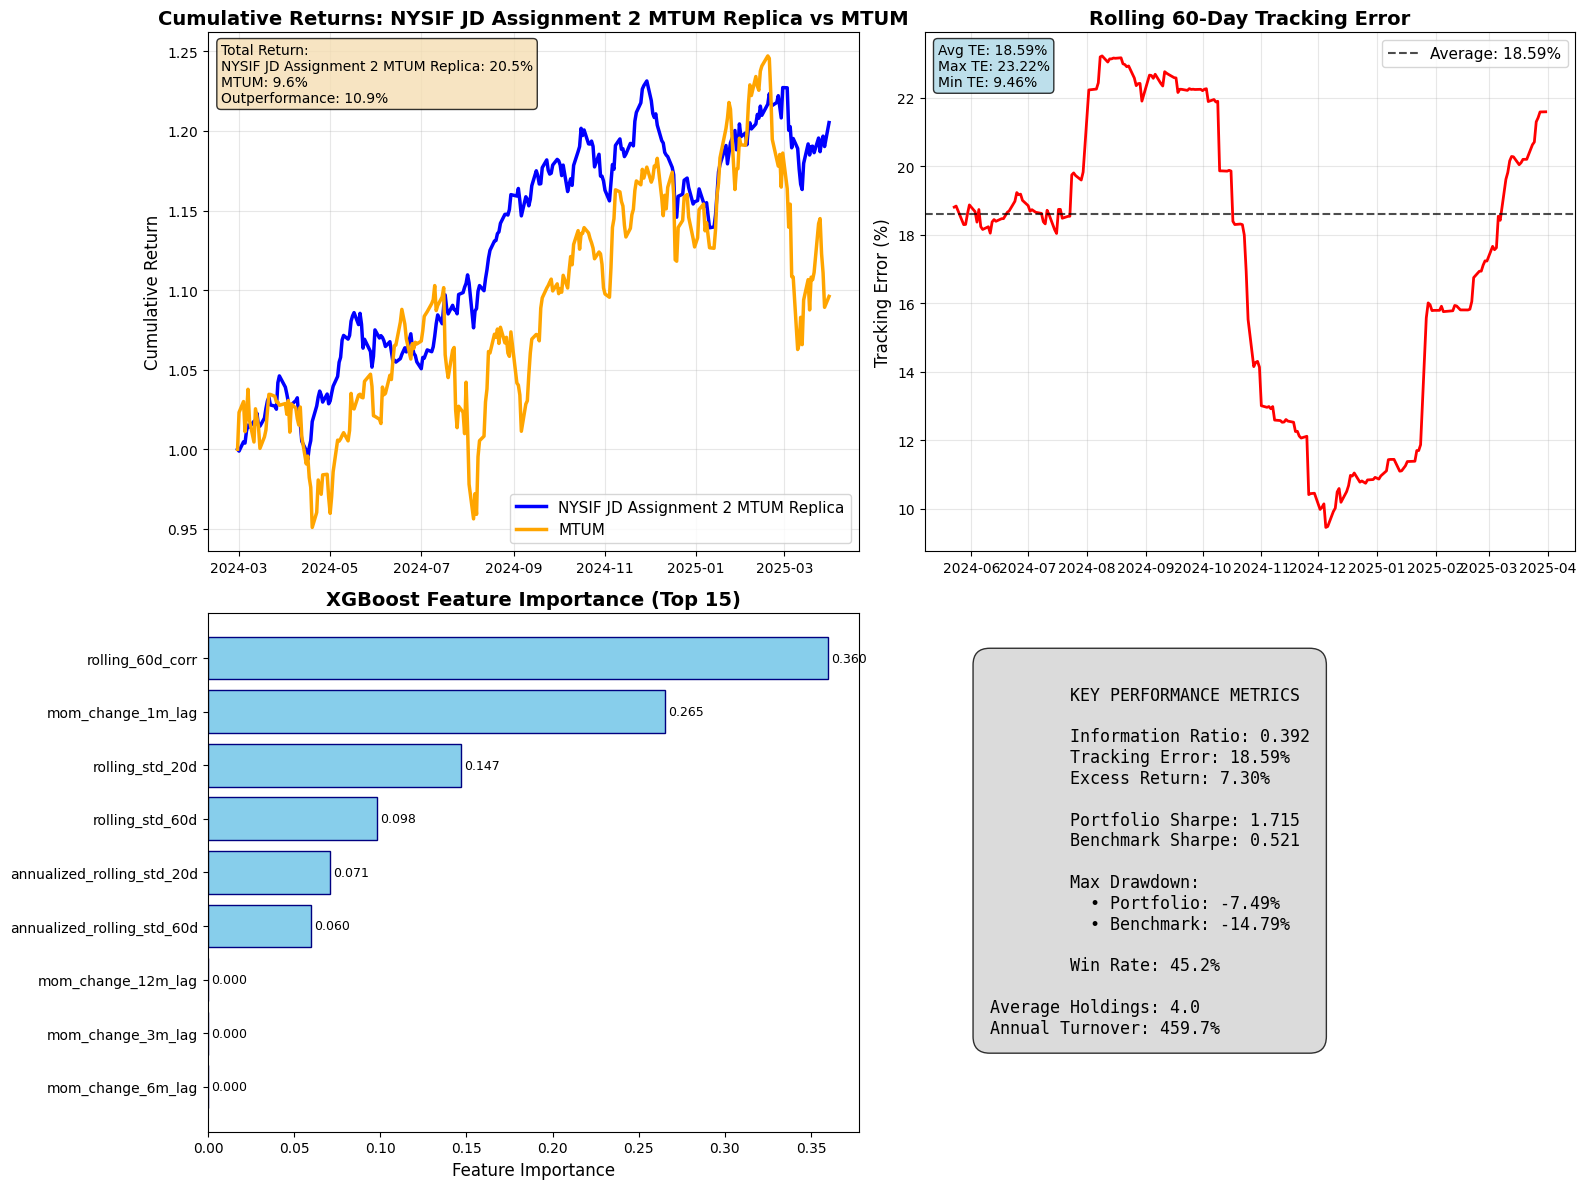


📊 Creating Full Backtest Analysis for period: 2024-11-30 to 2025-07-31
   📈 Portfolio returns: 101 days
   📊 Benchmark returns: 101 days
   ✅ Successfully aligned data: 101 days from 2024-11-01 to 2025-03-31
   📈 Portfolio data: 101 days from 2024-11-01 to 2025-03-31
💾 Saved comprehensive analysis chart: full_backtest_analysis_20250815_074749.png


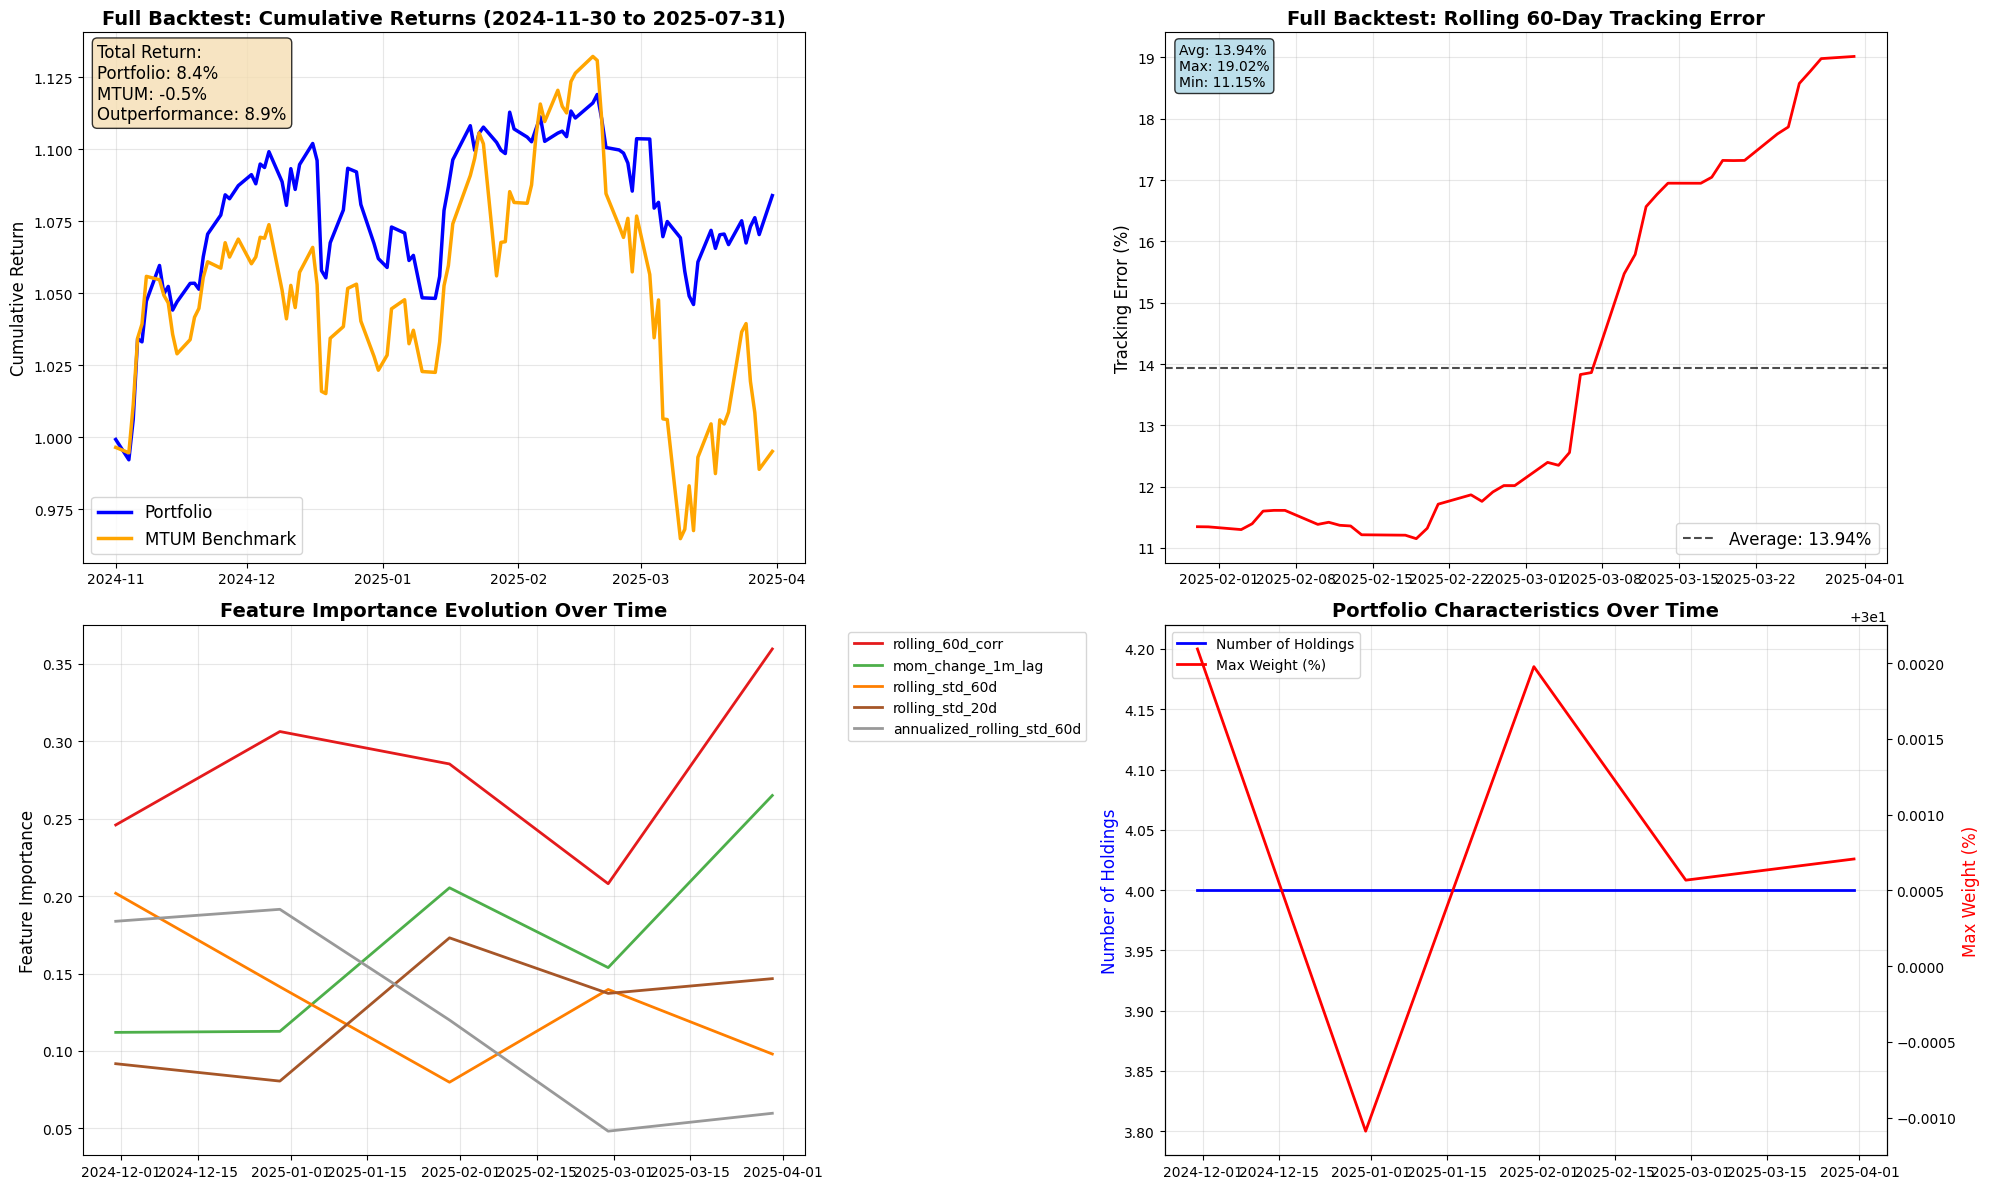

In [28]:

# # Generate complete performance report
# key_statistics, performance_data = generate_portfolio_performance_report(
#     portfolio_returns=portfolio_historical_returns,
#     benchmark_returns=benchmark_returns,  # Your MTUM benchmark
#     feature_importance_df=feature_importance,  # From XGBoost model
#     portfolio_weights_history=None,  # Optional: DataFrame with historical weights
#     portfolio_name="My Replica Portfolio",
#     benchmark_name="MTUM"
# )

# Get summary DataFrames for immediate analysis
summary_dfs = main_backtest_storage.get_summary_dataframes()
print(f"\nAvailable summary DataFrames: {list(summary_dfs.keys())}")

# REPLACE WITH THIS SIMPLER APPROACH:
if weights_df is not None:
    print(f"\n✅ Portfolio weights history available for further analysis")
    # print(f"   Shape: {weights_df.shape}")
    # print(f"   You can now use 'weights_df' in any performance analysis")
else:
    print(f"\n⚠️  No weights history available")

# Debug what's in summary_dfs
if 'daily_returns' in summary_dfs:
    daily_ret_data = summary_dfs['daily_returns']
    #print(f"Daily returns type: {type(daily_ret_data)}")
    #print(f"Daily returns shape: {daily_ret_data.shape if hasattr(daily_ret_data, 'shape') else 'No shape'}")
    #print(f"Daily returns cols: {summary_dfs}")
    
    # If it's a DataFrame, extract the Series
    if isinstance(daily_ret_data, pd.DataFrame):
        if daily_ret_data.shape[1] == 1:
            portfolio_returns_final = daily_ret_data.iloc[:, 0]  # Take first column
        else:
            print(f"Multiple columns in daily_returns: {daily_ret_data.columns.tolist()}")
            portfolio_returns_final = daily_ret_data.iloc[:, 0]  # Take first column anyway
    else:
        portfolio_returns_final = daily_ret_data
        
    #print(f"Final portfolio returns shape: {portfolio_returns_final.shape}")


key_statistics, performance_data = generate_portfolio_performance_report(
    portfolio_returns=portfolio_historical_returns,
    benchmark_returns=benchmark_returns,
    feature_importance_df=feature_importance,
    portfolio_weights_history=weights_df, #summary_dfs['portfolio_weights'],  # ← Add this!
    portfolio_name="NYSIF JD Assignment 2 MTUM Replica",
    benchmark_name="MTUM"
)


# After your main loop completes and before file organization:
test_period_start = pd.to_datetime(new_month_end_dates[START_INDEX], format="%Y-%m-%d")  # First month in your test
test_period_end = pd.to_datetime(new_month_end_dates[END_INDEX],  format="%Y-%m-%d")   # Last month in your test

# Create comprehensive analysis
comprehensive_chart = create_full_backtest_analysis(
    main_backtest_storage=main_backtest_storage,
    monthly_weights_history=monthly_weights_history,
    feature_importance_history=feature_importance_history,
    test_period_start=test_period_start,
    test_period_end=test_period_end
)

